In [1]:
"""
Enhanced AI Text Detection Pipeline
-----------------------------------
核心改进:
1. 更好的LLM选择（T5/GPT-2用于重写）
2. 多维度特征提取
3. 更智能的扰动策略
4. 集成学习方法


"""

# 尝试导入，如果失败则提示安装
from __future__ import annotations
import os
import json
import hashlib
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass
from tqdm import tqdm
import random
import pickle
from dotenv import load_dotenv

load_dotenv()

# OpenAI library imports
import asyncio
import openai  # Good for catching error types like openai.RateLimitError
from openai import OpenAI
from openai import AsyncOpenAI
import tiktoken

# 基础库
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import torch

# 可视化库
import matplotlib.pyplot as plt
import seaborn as sns

import os, time, hashlib, json, random
from typing import List, Tuple

import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Transformers
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    AutoTokenizer,
    AutoModel,
)
from sentence_transformers import SentenceTransformer

# 文本处理
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# 文本扰动库
try:
    import nlpaug.augmenter.word as naw
    import nlpaug.augmenter.sentence as nas
except ImportError:
    print("nlpaug not found, installing...")
    os.system("pip install nlpaug")
    import nlpaug.augmenter.word as naw
    import nlpaug.augmenter.sentence as nas

# Transformers 和 sentence-transformers

from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    GPT2LMHeadModel,
    GPT2Tokenizer,
)
from sentence_transformers import SentenceTransformer
from dataclasses import dataclass, field
from typing import List, Optional

# NLTK数据下载
import nltk

print("Downloading required NLTK data...")
nltk.download("punkt_tab")
nltk.download("punkt", quiet=True)
nltk.download("averaged_perceptron_tagger", quiet=True)
nltk.download("averaged_perceptron_tagger_eng", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)
nltk.download("stopwords", quiet=True)
print("NLTK data download completed.")
import logging

# 配置日志
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)


@dataclass
class DetectionConfig:
    """检测配置类"""

    # 模型选择
    revision_model: str = "t5-small"
    embedding_model: str = "all-MiniLM-L6-v2"

    api_key: Optional[str] = field(default_factory=lambda: os.getenv("OPENAI_API_KEY"))
    base_url: Optional[str] = field(
        default_factory=lambda: os.getenv("OPENAI_BASE_URL")
    )

    # 扰动参数
    perturbation_rate: float = 0.15
    # 【修正】使用field(default_factory=...)来避免可变默认参数问题
    perturbation_methods: List[str] = field(
        default_factory=lambda: ["synonym", "contextual"]
    )

    # 检测参数
    similarity_threshold: float = 0.95  # 建议使用0.85作为更稳健的默认值
    use_ml_classifier: bool = True

    # 批处理
    batch_size: int = 16
    max_length: int = 512

    def __post_init__(self):
        if self.perturbation_methods is None:
            self.perturbation_methods = ["synonym", "contextual", "backtranslation"]


class EnhancedTextPerturber:
    """增强的文本扰动器"""

    def __init__(self, config: DetectionConfig):
        self.config = config
        self._init_augmenters()

    def _init_augmenters(self):
        """初始化各种扰动器"""
        self.augmenters = {
            "synonym": naw.SynonymAug(
                aug_src="wordnet", aug_p=self.config.perturbation_rate
            ),
            "contextual": naw.ContextualWordEmbsAug(
                model_path="distilbert-base-uncased",
                action="substitute",
                aug_p=self.config.perturbation_rate,
            ),
            "random_swap": naw.RandomWordAug(
                action="swap", aug_p=self.config.perturbation_rate
            ),
            "spelling": naw.SpellingAug(aug_p=self.config.perturbation_rate),
        }

    def perturb(self, text: str, method: Optional[str] = None) -> str:
        """
        智能扰动策略

        Args:
            text: 原始文本
            method: 指定方法，None则随机选择
        Returns:
            扰动后的文本
        """
        if method is None:
            method = np.random.choice(self.config.perturbation_methods)

        try:
            if method == "backtranslation":
                return self._backtranslate(text)
            elif method in self.augmenters:
                augmented = self.augmenters[method].augment(text)
                return augmented[0] if isinstance(augmented, list) else augmented
            else:
                # 混合扰动
                return self._mixed_perturbation(text)
        except Exception as e:
            print(f"Perturbation failed: {e}")
            return self._simple_perturb(text)

    def _mixed_perturbation(self, text: str) -> str:
        """混合多种扰动方法"""
        sentences = sent_tokenize(text)
        perturbed_sentences = []

        for sent in sentences:
            # 随机选择扰动方法
            method = np.random.choice(list(self.augmenters.keys()))
            try:
                perturbed = self.augmenters[method].augment(sent)
                perturbed_sent = (
                    perturbed[0] if isinstance(perturbed, list) else perturbed
                )
                perturbed_sentences.append(perturbed_sent)
            except:
                perturbed_sentences.append(sent)

        return " ".join(perturbed_sentences)

    def _simple_perturb(self, text: str) -> str:
        """简单扰动作为后备"""
        words = text.split()

        # 随机替换15%的词
        num_changes = max(1, int(len(words) * self.config.perturbation_rate))
        indices = np.random.choice(
            range(len(words)), size=min(num_changes, len(words)), replace=False
        )

        for idx in indices:
            # 简单的字符级修改
            word = words[idx]
            if len(word) > 3:
                words[idx] = word[:-1] + np.random.choice(list("aeiou"))

        return " ".join(words)

    def _backtranslate(self, text: str) -> str:
        """反向翻译（需要翻译API）"""
        # 这里只是示例，实际需要调用翻译API
        return text


class EnhancedLLMReviser:
    """增强的LLM重写器"""

    def __init__(self, config: DetectionConfig):
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.client = None
        self.model = None
        self.tokenizer = None
        self._init_reviser()

    def _init_model(self):
        model_name = self.config.revision_model
        """初始化重写模型"""
        if self.config.revision_model.startswith("t5"):
            # T5模型更适合文本重写任务
            self.tokenizer = T5Tokenizer.from_pretrained(self.config.revision_model)
            self.model = T5ForConditionalGeneration.from_pretrained(
                self.config.revision_model
            )
        elif self.config.revision_model == "gpt2":
            # GPT-2作为备选
            self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
            self.model = GPT2LMHeadModel.from_pretrained("gpt2")
            self.tokenizer.pad_token = self.tokenizer.eos_token
        elif model_name.startswith("gpt-"):
            # 初始化OpenAI API客户端
            api_key = self.config.api_key or os.getenv("OPENAI_API_KEY")
            if not api_key:
                raise ValueError(
                    "请在DetectionConfig中提供api_key或设置OPENAI_API_KEY环境变量"
                )

            self.client = OpenAI(api_key=api_key, base_url=self.config.base_url)
            self.max_retries = 3
            self.retry_delay = 1.0
            print(f"OpenAI client initialized for model: {model_name}")
            if self.config.base_url:
                print(f"Using custom base URL: {self.config.base_url}")
        else:
            print(
                f"Warning: Unknown revision model '{model_name}'. Will use rule-based fallback."
            )

        self.model.to(self.device)
        self.model.eval()

    def _init_reviser(self):
        """根据配置初始化重写模型或API客户端"""
        model_name = self.config.revision_model

        if model_name.startswith("t5"):
            self.tokenizer = T5Tokenizer.from_pretrained(model_name)
            self.model = T5ForConditionalGeneration.from_pretrained(model_name)
            self.model.to(self.device).eval()
            print(f"Local T5 model loaded: {model_name}")

        elif model_name == "gpt2":
            self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
            self.model = GPT2LMHeadModel.from_pretrained(model_name)
            self.tokenizer.pad_token = self.tokenizer.eos_token
            self.model.to(self.device).eval()
            print(f"Local GPT-2 model loaded: {model_name}")

        elif model_name.startswith("gpt-"):
            # 初始化OpenAI API客户端
            api_key = self.config.api_key or os.getenv("OPENAI_API_KEY")
            if not api_key:
                raise ValueError(
                    "请在DetectionConfig中提供api_key或设置OPENAI_API_KEY环境变量"
                )

            # self.client = OpenAI(api_key=api_key, base_url=self.config.base_url)
            self.client = AsyncOpenAI(
                api_key=api_key, base_url=self.config.base_url
            )  # Using Asynchronous Clients
            self.max_retries = 3
            self.retry_delay = 1.0
            print(f"OpenAI client initialized for model: {model_name}")
            if self.config.base_url:
                print(f"Using custom base URL: {self.config.base_url}")
        else:
            print(
                f"Warning: Unknown revision model '{model_name}'. Will use rule-based fallback."
            )

    # def revise(self, text: str, cache: Dict[str, str]) -> str:
    async def revise(
        self, original_text: str, perturbed_text: str, cache: Dict[str, str]
    ) -> str:  # change to async def
        """
        使用LLM重写文本

        Args:
            original_text: 待重写文本
            cache: 缓存字典
        Returns:
            重写后的文本
        """
        # 生成缓存键
        cache_key = hashlib.md5(
            f"{original_text}_{self.config.revision_model}".encode()
        ).hexdigest()

        # Check if the result for the original text is already in the cache
        if cache_key in cache:
            return cache[cache_key]

        # print(f"\norigin text: {original_text}")

        try:
            model_name = self.config.revision_model
            revised = ""
            if model_name.startswith("t5") or model_name == "gpt2":
                if model_name.startswith("t5"):
                    revised = self._revise_with_t5(perturbed_text)
                    # print(f"t5 rewrite: {revised}")
                else:  # gpt2
                    revised = self._revise_with_gpt2(perturbed_text)
                    # print(f"gpt2 rewrite: {revised}")
            elif model_name.startswith("gpt-"):
                # api rewrite
                # revised = self._revise_with_api(perturbed_text)
                revised = await self._revise_with_api(perturbed_text)  # change to await
                # print(f"gpt3.5 rewrite: {revised}")
            else:
                revised = self._rule_based_revision(perturbed_text)

            cache[cache_key] = revised
            return revised

        except Exception as e:
            print(f"Revision failed with model {self.config.revision_model}: {e}")
            fallback_revision = self._rule_based_revision(perturbed_text)
            cache[cache_key] = fallback_revision
            return fallback_revision

    def _revise_with_t5(self, text: str) -> str:
        """使用T5模型重写"""
        # T5需要特定的提示格式
        prompt = f"paraphrase: {text}"

        inputs = self.tokenizer.encode(
            prompt,
            return_tensors="pt",
            max_length=512,  # 对输入进行截断的最大长度
            truncation=True,
        ).to(self.device)

        with torch.no_grad():
            # 使用束搜索 (Beam Search) 以获得更高质量和更稳定的输出
            outputs = self.model.generate(
                inputs,
                # --- 解码策略修改 ---
                num_beams=4,  # 修改：设置束的宽度，4或5是常用值
                early_stopping=True,  # 新增：当所有束都完成时提前停止
                # --- 长度控制优化 ---
                max_length=256,  # 修改：为输出设置一个固定的最大长度
                min_length=40,  # 新增：设置一个合理的最小长度，防止输出过短
                # --- 质量优化 ---
                repetition_penalty=1.2,  # 新增：轻微惩罚重复，提升多样性
            )

            # 注意：使用 beam search 时，不需要 do_sample, temperature, top_p

        revised = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return revised

    def _revise_with_gpt2(self, text: str) -> str:
        """使用GPT-2模型重写"""
        try:
            prompt_templates = [
                f"Paraphrase the following text while keeping the same meaning: {text}\n\nParaphrased version:",
                f"Rewrite this sentence in a different way: {text}\n\nRewritten:",
                f"Express this differently: {text}\n\nAlternative expression:",
            ]
            prompt = np.random.choice(prompt_templates)
            inputs = self.tokenizer.encode(
                prompt,
                return_tensors="pt",
                max_length=512,
                truncation=True,
                padding=True,  # Ensure padding is enabled to handle the mask
            )
            input_ids = inputs.input_ids.to(self.device)
            attention_mask = inputs.attention_mask.to(self.device)

            with torch.no_grad():
                outputs = self.model.generate(
                    input_ids=input_ids,  # Pass input_ids explicitly
                    attention_mask=attention_mask,
                    max_length=min(len(input_ids[0]) + 100, 1024),
                    num_return_sequences=1,
                    temperature=0.8,
                    do_sample=True,
                    top_p=0.9,
                    pad_token_id=self.tokenizer.eos_token_id,
                    eos_token_id=self.tokenizer.eos_token_id,
                    no_repeat_ngram_size=3,
                    # early_stopping=True,
                )

            #
            full_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

            rewritten = ""
            for marker in [
                "Paraphrased version:",
                "Rewritten:",
                "Alternative expression:",
            ]:
                if marker in full_text:
                    rewritten = full_text.split(marker)[-1].strip()
                    break

            if not rewritten:
                rewritten = full_text[len(prompt) :].strip()

            if "\n" in rewritten:
                rewritten = rewritten.split("\n")[0]
            if "." in rewritten:
                rewritten = rewritten.split(".")[0] + "."

            return rewritten if rewritten else text

        except Exception as e:
            print(f"  修复版重写失败: {e}")
            return text

    # def _revise_with_api(self, text: str) -> str:
    async def _revise_with_api(self, text: str) -> str:  # change to async def
        """Use OpenAI API with better prompting strategy"""
        if not self.client:
            raise ValueError("OpenAI client not initialized.")

        # Better prompt that encourages standardization
        system_prompt = """You are a professional editor. Your task is to rewrite the given text to make it more formal, standardized, and academic in style. 

Key guidelines:
- Replace casual expressions with formal language
- Use precise technical terms where appropriate
- Maintain professional tone throughout
- Standardize sentence structure
- Remove colloquialisms and personal expressions
- Keep the core meaning but express it in a more refined way

The more casual or informal the original text, the more changes you should make."""

        user_prompt = f"Please rewrite this text in a formal, academic style:\n\n{text}"

        for attempt in range(self.max_retries):
            try:
                response = await self.client.chat.completions.create(  # change to await
                    model=self.config.revision_model,
                    messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": user_prompt},
                    ],
                    temperature=0.3,  # Lower temperature for more consistent output
                    top_p=0.9,
                )
                return response.choices[0].message.content.strip()

            except Exception as e:
                print(f"API error (attempt {attempt + 1}): {e}")
                if attempt < self.max_retries - 1:
                    await asyncio.time.sleep(
                        self.retry_delay
                    )  # Using asynchronous sleep
                else:
                    return text

        return text

    def _rule_based_revision(self, text: str) -> str:
        """基于规则的重写"""
        import re

        # 句子重排
        sentences = sent_tokenize(text)
        if len(sentences) > 2:
            # 随机调整句子顺序（保持逻辑性）
            sentences = self._reorder_sentences(sentences)

        # 同义词替换
        revised_sentences = []
        for sent in sentences:
            # 简单的同义词映射
            synonyms = {
                "important": "significant",
                "however": "nevertheless",
                "therefore": "thus",
                "because": "since",
                "many": "numerous",
                "show": "demonstrate",
            }

            for word, syn in synonyms.items():
                sent = re.sub(r"\b" + word + r"\b", syn, sent, flags=re.IGNORECASE)

            revised_sentences.append(sent)

        return " ".join(revised_sentences)

    def _reorder_sentences(self, sentences: List[str]) -> List[str]:
        """智能句子重排"""
        # 保持第一句和最后一句
        if len(sentences) <= 2:
            return sentences

        first = sentences[0]
        last = sentences[-1]
        middle = sentences[1:-1]

        # 打乱中间句子
        np.random.shuffle(middle)

        return [first] + middle + [last]


class MultiFeatureExtractor:
    """多维度特征提取器"""

    def __init__(self, config: DetectionConfig):
        self.config = config
        self.sentence_model = SentenceTransformer(config.embedding_model)
        self._init_linguistic_features()

    def _init_linguistic_features(self):
        """初始化语言学特征提取"""
        try:
            nltk.download("punkt", quiet=True)
            nltk.download("averaged_perceptron_tagger", quiet=True)
            nltk.download("stopwords", quiet=True)
            self.stop_words = set(stopwords.words("english"))
        except:
            self.stop_words = set()

    def extract_features(self, original: str, revised: str) -> Dict[str, float]:
        """
        提取多维度特征

        Returns:
            特征字典
        """
        features = {}

        # 1. 语义相似度
        features["semantic_similarity"] = self._compute_semantic_similarity(
            original, revised
        )

        # 2. 词汇级特征
        features.update(self._extract_lexical_features(original, revised))

        # 3. 句法特征
        features.update(self._extract_syntactic_features(original, revised))

        # 4. 风格特征
        features.update(self._extract_stylistic_features(original, revised))

        # 5. 编辑距离特征
        features.update(self._extract_edit_features(original, revised))

        return features

    def _compute_semantic_similarity(self, text1: str, text2: str) -> float:
        """计算语义相似度"""
        emb1 = self.sentence_model.encode(text1)
        emb2 = self.sentence_model.encode(text2)

        from sklearn.metrics.pairwise import cosine_similarity

        return float(cosine_similarity([emb1], [emb2])[0, 0])

    def _extract_lexical_features(
        self, original: str, revised: str
    ) -> Dict[str, float]:
        """提取词汇级特征"""
        orig_words = set(word_tokenize(original.lower()))
        rev_words = set(word_tokenize(revised.lower()))

        # 词汇重叠率
        overlap = len(orig_words & rev_words)
        total = len(orig_words | rev_words)

        features = {
            "word_overlap_ratio": overlap / total if total > 0 else 0,
            "vocabulary_change_ratio": (
                len(orig_words ^ rev_words) / total if total > 0 else 0
            ),
            "unique_words_ratio": (
                len(rev_words - orig_words) / len(rev_words) if rev_words else 0
            ),
        }

        # 停用词比例变化
        orig_stop = len([w for w in orig_words if w in self.stop_words])
        rev_stop = len([w for w in rev_words if w in self.stop_words])

        features["stopword_ratio_change"] = abs(
            (orig_stop / len(orig_words) if orig_words else 0)
            - (rev_stop / len(rev_words) if rev_words else 0)
        )

        return features

    def _extract_syntactic_features(
        self, original: str, revised: str
    ) -> Dict[str, float]:
        """提取句法特征"""
        orig_sents = sent_tokenize(original)
        rev_sents = sent_tokenize(revised)

        features = {
            "sentence_count_ratio": (
                len(rev_sents) / len(orig_sents) if orig_sents else 1
            ),
            "avg_sentence_length_change": (
                abs(
                    np.mean([len(word_tokenize(s)) for s in orig_sents])
                    - np.mean([len(word_tokenize(s)) for s in rev_sents])
                )
                if orig_sents and rev_sents
                else 0
            ),
        }

        # POS标签分布变化
        try:
            orig_pos = nltk.pos_tag(word_tokenize(original))
            rev_pos = nltk.pos_tag(word_tokenize(revised))

            # 计算主要词性比例变化
            for pos_type in ["NN", "VB", "JJ", "RB"]:  # 名词、动词、形容词、副词
                orig_count = sum(1 for _, pos in orig_pos if pos.startswith(pos_type))
                rev_count = sum(1 for _, pos in rev_pos if pos.startswith(pos_type))

                features[f"pos_{pos_type}_ratio_change"] = abs(
                    (orig_count / len(orig_pos) if orig_pos else 0)
                    - (rev_count / len(rev_pos) if rev_pos else 0)
                )
        except:
            pass

        return features

    def _extract_stylistic_features(
        self, original: str, revised: str
    ) -> Dict[str, float]:
        """提取风格特征"""
        features = {}

        # 标点符号使用变化
        orig_punct = sum(1 for c in original if c in ".,!?;:")
        rev_punct = sum(1 for c in revised if c in ".,!?;:")

        features["punctuation_ratio_change"] = abs(
            (orig_punct / len(original) if original else 0)
            - (rev_punct / len(revised) if revised else 0)
        )

        # 大写字母比例变化
        orig_caps = sum(1 for c in original if c.isupper())
        rev_caps = sum(1 for c in revised if c.isupper())

        features["capitalization_ratio_change"] = abs(
            (orig_caps / len(original) if original else 0)
            - (rev_caps / len(revised) if revised else 0)
        )

        # 平均词长变化
        orig_words = word_tokenize(original)
        rev_words = word_tokenize(revised)

        features["avg_word_length_change"] = (
            abs(
                np.mean([len(w) for w in orig_words])
                - np.mean([len(w) for w in rev_words])
            )
            if orig_words and rev_words
            else 0
        )

        return features

    def _extract_edit_features(self, original: str, revised: str) -> Dict[str, float]:
        """提取编辑距离相关特征"""
        from difflib import SequenceMatcher

        # 字符级相似度
        char_similarity = SequenceMatcher(None, original, revised).ratio()

        # 词级相似度
        orig_words = word_tokenize(original)
        rev_words = word_tokenize(revised)
        word_similarity = SequenceMatcher(None, orig_words, rev_words).ratio()

        features = {
            "char_level_similarity": char_similarity,
            "word_level_similarity": word_similarity,
            "length_ratio": len(revised) / len(original) if original else 1,
        }

        return features


class AITextDetector:
    """主检测器类"""

    def __init__(self, config: DetectionConfig = None):
        self.config = config or DetectionConfig()
        self.perturber = EnhancedTextPerturber(self.config)
        self.reviser = EnhancedLLMReviser(self.config)
        self.feature_extractor = MultiFeatureExtractor(self.config)
        self.classifier = None
        self.scaler = StandardScaler()
        self.cache = {}
        self.api_concurrency_limit = asyncio.Semaphore(10)

    # In the AITextDetector class

    async def detect_batch(
        self, texts: List[str], labels: Optional[List[int]] = None
    ) -> Dict[str, np.ndarray]:
        """
        Asynchronously detects text in a batch, with robust caching and parallel API calls.
        """
        all_features = []
        all_scores = []

        if not texts:
            # Handle the case where an empty list is passed
            return {
                "predictions": np.array([]),
                "probabilities": np.array([]),
                "features": np.array([]),
                "similarity_scores": np.array([]),
            }

        print("Processing texts...")

        # Step 1: Perform synchronous, CPU-bound perturbation first.
        perturbed_texts = [
            self.perturber.perturb(text) for text in tqdm(texts, desc="Perturbing")
        ]

        # Step 2: Define a helper function to manage semaphore and call the new revise method.
        # This helper will be used to create our list of concurrent tasks.
        async def revise_with_limit(original_text, perturbed_text):
            async with self.api_concurrency_limit:
                # Call the updated revise function with both original and perturbed text
                return await self.reviser.revise(
                    original_text, perturbed_text, self.cache
                )

        # Step 3: Create a list of NEW coroutine tasks.
        # Each task is a call to our helper function with a pair of original and perturbed texts.
        print(f"Revising texts with {self.reviser.config.revision_model}...")
        revision_tasks = [
            revise_with_limit(orig, pert) for orig, pert in zip(texts, perturbed_texts)
        ]

        # Step 4: Concurrently run all revision tasks using asyncio.gather.
        # This preserves the order of the results and is wrapped in tqdm for a progress bar.
        all_revised_texts = await asyncio.gather(
            *tqdm(revision_tasks, desc="Revising", total=len(revision_tasks))
        )

        # Step 5: Process the results. This part is synchronous again.
        print("Extracting features...")
        for i, original_text in enumerate(texts):
            # The order is preserved, so we can safely pair original and revised texts.
            revised_text = all_revised_texts[i]
            features = self.feature_extractor.extract_features(
                original_text, revised_text
            )
            all_features.append(features)
            all_scores.append(features.get("semantic_similarity", 0.5))

        # --- The rest of the function remains the same ---
        feature_matrix = pd.DataFrame(all_features).fillna(0).values

        if self.config.use_ml_classifier:
            if labels is not None and self.classifier is None:
                self._train_classifier(feature_matrix, labels)

            if self.classifier is not None:
                feature_matrix_scaled = self.scaler.transform(feature_matrix)
                predictions = self.classifier.predict(feature_matrix_scaled)
                probabilities = self.classifier.predict_proba(feature_matrix_scaled)[
                    :, 1
                ]
            else:
                # Fallback if classifier isn't trained
                predictions = (
                    np.array(all_scores) > self.config.similarity_threshold
                ).astype(int)
                probabilities = np.array(all_scores)
        else:
            # Logic for when the ML classifier is turned off
            predictions = (
                np.array(all_scores) > self.config.similarity_threshold
            ).astype(int)
            probabilities = np.array(all_scores)

        return {
            "predictions": predictions,
            "probabilities": probabilities,
            "features": feature_matrix,
            "similarity_scores": np.array(all_scores),
        }

    def _train_classifier(self, features: np.ndarray, labels: List[int]):
        """训练机器学习分类器"""
        print("Training classifier...")

        # 标准化特征
        features_scaled = self.scaler.fit_transform(features)

        # 使用随机森林
        self.classifier = RandomForestClassifier(
            n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
        )

        self.classifier.fit(features_scaled, labels)

        # 特征重要性
        feature_names = list(pd.DataFrame(features).columns)
        importances = self.classifier.feature_importances_

        print("\nTop 10 Most Important Features:")
        for feat, imp in sorted(
            zip(feature_names, importances), key=lambda x: x[1], reverse=True
        )[:10]:
            print(f"  {feat}: {imp:.4f}")

    def save_model(self, path: str):
        """保存模型"""
        import pickle

        model_data = {
            "classifier": self.classifier,
            "scaler": self.scaler,
            "config": self.config,
            "cache": self.cache,
        }

        with open(path, "wb") as f:
            pickle.dump(model_data, f)

        print(f"Model saved to {path}")

    def load_model(self, path: str):
        """加载模型"""
        import pickle

        with open(path, "rb") as f:
            model_data = pickle.load(f)

        self.classifier = model_data["classifier"]
        self.scaler = model_data["scaler"]
        self.config = model_data["config"]
        self.cache = model_data["cache"]

        print(f"Model loaded from {path}")


# 数据集加载函数
class CustomDataLoader:
    """数据加载器类"""

    def __init__(self, data_dir: str = "./data"):
        """
        初始化数据加载器

        Args:
            data_dir: 数据文件默认目录
        """
        self.data_dir = data_dir
        if not os.path.exists(data_dir):
            os.makedirs(data_dir)
            logger.info(f"Created data directory: {data_dir}")

    def load_data(self, path: str) -> pd.DataFrame:
        """
        读取带有 'text' 与 'label' 列的数据集，并返回 DataFrame。
        支持金融数据集格式和通用格式。

        Args:
            path: 数据文件路径、'finance' 表示使用金融数据集、'sample' 表示创建示例数据
        Returns:
            df: columns = ['id', 'text', 'label']
        """
        if path == "finance":
            return self.load_finance_dataset()
        if path == "sample":
            return self.create_sample_dataset()
        elif path == "test":
            return self.load_origin_dataset()

        # 如果是相对路径，添加数据目录前缀
        if not os.path.isabs(path) and not os.path.exists(path):
            path = os.path.join(self.data_dir, path)

        try:
            if path.endswith(".csv"):
                df = pd.read_csv(path)
            elif path.endswith(".jsonl"):
                df = pd.read_json(path, lines=True)
            elif path.endswith(".json"):
                df = pd.read_json(path)
            else:
                raise ValueError(f"Unsupported file format: {path}")

            # 确保有必要的列
            if "text" not in df.columns:
                raise ValueError("Missing 'text' column in dataset")
            if "label" not in df.columns:
                raise ValueError("Missing 'label' column in dataset")

            # 如果没有id列，自动生成
            if "id" not in df.columns:
                df["id"] = range(len(df))

            # 数据清洗
            df = df.dropna(subset=["text", "label"])
            df = df[df["text"].str.len() > 10]  # 过滤太短的文本

            logger.info(f"Loaded {len(df)} samples from {path}")
            logger.info(f"Label distribution: {df['label'].value_counts().to_dict()}")

            return df[["id", "text", "label"]]

        except FileNotFoundError:
            logger.warning(f"File {path} not found. Creating sample dataset...")
            return self.create_sample_dataset()

    def find_finance_data_files(self) -> Dict[str, str]:
        """查找金融数据集文件"""
        logger.info("Searching for finance data files...")

        # 本地环境路径
        possible_paths = [
            self.data_dir,
            os.path.join(self.data_dir, "finance"),
            os.path.join(self.data_dir, "finance-dataset"),
            "./finance_data",
            ".",
            "./data",
        ]

        files_found = {}

        for path in possible_paths:
            if os.path.exists(path):
                logger.debug(f"Checking path: {path}")
                for root, dirs, files in os.walk(path):
                    for file in files:
                        if "revised_human_finance" in file or "revised_human" in file:
                            files_found["revised_human"] = os.path.join(root, file)
                        elif (
                            "revised_chatgpt_finance" in file
                            or "revised_chatgpt" in file
                        ):
                            files_found["revised_chatgpt"] = os.path.join(root, file)
                        elif "finance.jsonl" in file:
                            files_found["original"] = os.path.join(root, file)

        return files_found

    def load_finance_dataset(self) -> pd.DataFrame:
        """
        加载金融数据集 - 使用修订后的文本作为数据
        修复了多行JSON解析问题

        Returns:
            df: columns = ['id', 'text', 'label']
            其中text是修订后的文本，label: 0=human, 1=chatgpt
        """
        files = self.find_finance_data_files()

        logger.info("Loading finance datasets...")
        logger.info(f"Found files: {list(files.keys())}")

        all_texts = []
        all_labels = []

        # 1. 加载修订后的人类文本（每行一个JSON对象）
        if "revised_human" in files:
            try:
                logger.info(
                    f"Loading revised human texts from: {files['revised_human']}"
                )
                with open(files["revised_human"], "r", encoding="utf-8") as f:
                    for line_no, line in enumerate(f, 1):
                        line = line.strip()
                        if line:
                            try:
                                # 每行是一个独立的JSON对象
                                item = json.loads(line)
                                for idx, text in item.items():
                                    # 清理文本
                                    cleaned_text = (
                                        text.strip()
                                        .replace("\\n\\n", " ")
                                        .replace("\\n", " ")
                                    )
                                    if len(cleaned_text) > 20:
                                        all_texts.append(cleaned_text)
                                        all_labels.append(0)  # 0 = human
                            except json.JSONDecodeError as e:
                                logger.warning(f"  Line {line_no} parse error: {e}")
                logger.info(
                    f"  Loaded {len([l for l in all_labels if l == 0])} human texts"
                )
            except Exception as e:
                logger.error(f"Error loading revised human texts: {e}")

        # 2. 加载修订后的ChatGPT文本（每行一个JSON对象）
        if "revised_chatgpt" in files:
            try:
                logger.info(
                    f"Loading revised ChatGPT texts from: {files['revised_chatgpt']}"
                )
                with open(files["revised_chatgpt"], "r", encoding="utf-8") as f:
                    for line_no, line in enumerate(f, 1):
                        line = line.strip()
                        if line:
                            try:
                                # 每行是一个独立的JSON对象
                                item = json.loads(line)
                                for idx, text in item.items():
                                    # 清理文本
                                    cleaned_text = (
                                        text.strip()
                                        .replace("\\n\\n", " ")
                                        .replace("\\n", " ")
                                    )
                                    if len(cleaned_text) > 20:
                                        all_texts.append(cleaned_text)
                                        all_labels.append(1)  # 1 = chatgpt
                            except json.JSONDecodeError as e:
                                logger.warning(f"  Line {line_no} parse error: {e}")
                logger.info(
                    f"  Loaded {len([l for l in all_labels if l == 1])} ChatGPT texts"
                )
            except Exception as e:
                logger.error(f"Error loading revised ChatGPT texts: {e}")

        # 4. 创建DataFrame
        df = pd.DataFrame(
            {"id": range(len(all_texts)), "text": all_texts, "label": all_labels}
        )

        # 打乱数据
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        df["id"] = range(len(df))

        logger.info(f"\n=== Dataset Summary ===")
        logger.info(f"Total samples: {len(df)}")
        logger.info(f"Human texts: {len(df[df['label'] == 0])}")
        logger.info(f"ChatGPT texts: {len(df[df['label'] == 1])}")

        # 显示示例
        if len(df) > 0:
            logger.info("\nSample texts:")
            for label in [0, 1]:
                label_name = "Human" if label == 0 else "ChatGPT"
                samples = df[df["label"] == label]
                if len(samples) > 0:
                    sample_text = samples.iloc[0]["text"]
                    logger.info(f"[{label_name}]: {sample_text[:100]}...")

        return df[["id", "text", "label"]]

    def create_sample_dataset(self) -> pd.DataFrame:
        """
        创建示例数据集用于测试

        Returns:
            df: columns = ['id', 'text', 'label']
        """
        sample_data = {
            "id": range(6),
            "text": [
                "There is most likely an error in the WSJ's data.  Yahoo! Finance reports the PE on the Russell 2000 to be 15 as of 83111 and SP 500 PE to be 13 (about the same as WSJ). Good catch, though!  E-mail WSJ, perhaps they will be grateful.",
                "I know this question has a lot of answers already, but I feel the answers are phrased either strongly against, or mildly for, co-signing. What it amounts down to is that this is a personal choice. You cannot receive reliable information as to whether or not co-signing this loan is a good move due to lack of information. The person involved is going to know the person they would be co-signing for, and the people on this site will only have their own personal preferences of experiences to draw from. You know if they are reliable, if they will be able to pay off the loan without need for the banks to come after you.  This site can offer general theories, but I think it should be kept in mind that this is wholly a personal decision for the person involved, and them alone to make based on the facts that they know and we do not.",
                "I think the best investment strategy is to diversify your portfolio across different asset classes.",
                "Historical price-to-earnings (PE) ratios for small-cap and large-cap stocks can vary significantly over time and may not be directly comparable due to the different characteristics of these two categories of stocks.Small-cap stocks, which are defined as stocks with a market capitalization of less than $2 billion, tend to be riskier and more volatile than large-cap stocks, which have a market capitalization of $10 billion or more. As a result, investors may be willing to pay a higher price for the potential growth opportunities offered by small-cap stocks, which can lead to higher PE ratios.On the other hand, large-cap stocks tend to be more established and stable, with a longer track record of earnings and revenue growth. As a result, these stocks may trade at lower PE ratios, as investors may be less willing to pay a premium for their growth potential.It is important to note that PE ratios are just one factor to consider when evaluating a stock and should not be used in isolation. Other factors, such as the company's financial health, industry trends, and macroeconomic conditions, can also impact a stock's PE ratio.",
                "Co-signing a personal loan for a friend or family member can be a risky proposition. When you co-sign a loan, you are agreeing to be responsible for the loan if the borrower is unable to make the payments. This means that if your friend or family member defaults on the loan, you will be on the hook for the remaining balance.There are a few things to consider before co-signing a personal loan for someone:Do you trust the borrower to make the payments on time and in full? If you are not confident that the borrower will be able to make the payments, it may not be a good idea to co-sign the loan.Can you afford to make the payments if the borrower defaults? If you are unable to make the payments, co-signing the loan could put your own financial stability at risk.What is the purpose of the loan? If the borrower is using the loan for a risky or questionable venture, it may not be worth the risk to co-sign.Is there another way for the borrower to get the loan without a co-signer? If the borrower has a good credit score and is able to qualify for a loan on their own, it may not be necessary for you to co-sign.In general, it is important to carefully consider the risks and potential consequences before co-signing a loan for someone. If you do decide to co-sign, it is a good idea to have a conversation with the borrower about their plans for making the loan payments and to have a clear understanding of your responsibilities as a co-signer.",
                "The optimal approach to risk management involves careful assessment of market conditions.",
            ],
            "label": [0, 0, 0, 1, 1, 1],  # 0=human, 1=AI
        }

        df = pd.DataFrame(sample_data)
        logger.info(f"Created sample dataset with {len(df)} examples")
        return df

    def load_origin_dataset(self) -> pd.DataFrame:
        """Load finance dataset from JSON Lines format"""
        files = self.find_finance_data_files()

        logger.info("Loading finance datasets...")
        logger.info(f"Found files: {list(files.keys())}")

        all_texts = []
        all_labels = []

        if "original" in files:
            finance_path = files["original"]
            logger.info(f"Loading from: {finance_path}")

            try:
                with open(finance_path, "r", encoding="utf-8") as f:
                    line_count = 0
                    for line_num, line in enumerate(f, 1):
                        line = line.strip()
                        if not line:
                            continue

                        try:
                            data = json.loads(line)
                            line_count += 1

                            # Extract human answers
                            human_answers = data.get("human_answers", [])
                            if (
                                human_answers
                                and len(human_answers) > 0
                                and human_answers[0]
                            ):
                                all_texts.append(human_answers[0])
                                all_labels.append(0)  # 0 for human

                            # Extract ChatGPT answers
                            chatgpt_answers = data.get("chatgpt_answers", [])
                            if (
                                chatgpt_answers
                                and len(chatgpt_answers) > 0
                                and chatgpt_answers[0]
                            ):
                                all_texts.append(chatgpt_answers[0])
                                all_labels.append(1)  # 1 for ChatGPT

                            # Log progress every 1000 lines
                            if line_num % 1000 == 0:
                                logger.info(
                                    f"Processed {line_num} lines, extracted {len(all_texts)} texts"
                                )

                        except json.JSONDecodeError as e:
                            logger.error(f"Error parsing line {line_num}: {e}")
                            logger.error(f"Line content: {line[:100]}...")
                            continue

                logger.info(f"Successfully loaded {line_count} JSON objects")
                logger.info(f"Total texts extracted: {len(all_texts)}")

            except FileNotFoundError:
                logger.error(f"File not found: {finance_path}")
                return self.create_sample_dataset()
            except Exception as e:
                logger.error(f"Error loading finance data: {e}")
                return self.create_sample_dataset()
        else:
            logger.warning("No finance data file found. Creating sample dataset...")
            return self.create_sample_dataset()

        if len(all_texts) == 0:
            logger.warning(
                "No texts extracted from finance data. Creating sample dataset..."
            )
            return self.create_sample_dataset()

        # Create DataFrame
        df = pd.DataFrame(
            {"id": range(len(all_texts)), "text": all_texts, "label": all_labels}
        )

        # Shuffle data
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        df["id"] = range(len(df))

        # Print summary
        logger.info(f"\n=== Dataset Summary ===")
        logger.info(f"Total samples: {len(df)}")
        logger.info(f"Human texts: {len(df[df['label'] == 0])}")
        logger.info(f"ChatGPT texts: {len(df[df['label'] == 1])}")

        # Show balance
        balance = len(df[df["label"] == 0]) / len(df) * 100
        logger.info(
            f"Dataset balance: {balance:.1f}% human, {100-balance:.1f}% ChatGPT"
        )

        # Display samples
        if len(df) > 0:
            logger.info("\nSample texts:")
            for label in [0, 1]:
                label_name = "Human" if label == 0 else "ChatGPT"
                samples = df[df["label"] == label]
                if len(samples) > 0:
                    sample_text = samples.iloc[0]["text"]
                    logger.info(f"\n[{label_name}]: {sample_text[:200]}...")

        return df[["id", "text", "label"]]

    def save_dataset(self, df: pd.DataFrame, filename: str, format: str = "csv"):
        """
        保存数据集到文件

        Args:
            df: 要保存的DataFrame
            filename: 文件名（不含扩展名）
            format: 文件格式 ('csv', 'json', 'jsonl')
        """
        filepath = os.path.join(self.data_dir, f"{filename}.{format}")

        if format == "csv":
            df.to_csv(filepath, index=False)
        elif format == "json":
            df.to_json(filepath, orient="records", indent=2)
        elif format == "jsonl":
            df.to_json(filepath, orient="records", lines=True)
        else:
            raise ValueError(f"Unsupported format: {format}")

        logger.info(f"Saved dataset to {filepath}")
        return filepath


def load_data(path: str) -> pd.DataFrame:

    loader = CustomDataLoader()
    return loader.load_data(path)


def load_finance_dataset() -> pd.DataFrame:

    loader = CustomDataLoader()
    return loader.load_finance_dataset()


def load_origin_dataset() -> pd.DataFrame:
    loader = CustomDataLoader()
    return loader.load_origin_dataset


def create_sample_dataset() -> pd.DataFrame:

    loader = CustomDataLoader()
    return loader.create_sample_dataset()


def evaluate_detector(
    detector: AITextDetector, texts: List[str], labels: List[int]
) -> Dict[str, float]:
    """
    评估检测器性能
    """
    results = detector.detect_batch(texts, labels)

    predictions = results["predictions"]
    probabilities = results["probabilities"]

    # 计算指标
    metrics = {
        "accuracy": accuracy_score(labels, predictions),
        "auc": roc_auc_score(labels, probabilities),
    }

    print("\n=== Evaluation Results ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")

    print("\nClassification Report:")
    print(classification_report(labels, predictions, target_names=["Human", "AI"]))

    # 分析相似度分布
    human_scores = results["similarity_scores"][np.array(labels) == 0]
    ai_scores = results["similarity_scores"][np.array(labels) == 1]

    print(f"\nSimilarity Score Distribution:")
    print(
        f"Human texts - Mean: {np.mean(human_scores):.3f}, Std: {np.std(human_scores):.3f}"
    )
    print(f"AI texts - Mean: {np.mean(ai_scores):.3f}, Std: {np.std(ai_scores):.3f}")

    return metrics


# ==============================================================================


def plot_roc_curves(results: Dict):
    """绘制所有实验的ROC曲线"""
    plt.figure(figsize=(10, 8))
    for name, result_data in results.items():
        fpr, tpr, _ = roc_curve(
            result_data["test_labels"], result_data["test_results"]["probabilities"]
        )
        auc = roc_auc_score(
            result_data["test_labels"], result_data["test_results"]["probabilities"]
        )
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_precision_recall_curves(results: Dict):
    """绘制所有实验的Precision-Recall曲线"""
    plt.figure(figsize=(10, 8))
    for name, result_data in results.items():
        precision, recall, _ = precision_recall_curve(
            result_data["test_labels"], result_data["test_results"]["probabilities"]
        )
        plt.plot(recall, precision, label=f"{name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_confusion_matrices(results: Dict):
    """绘制所有实验的混淆矩阵"""
    n_results = len(results)
    fig, axes = plt.subplots(1, n_results, figsize=(6 * n_results, 5))
    if n_results == 1:
        axes = [axes]  # Make it iterable
    for ax, (name, result_data) in zip(axes, results.items()):
        cm = confusion_matrix(
            result_data["test_labels"], result_data["test_results"]["predictions"]
        )
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            ax=ax,
            cbar=False,
            xticklabels=["Human", "AI"],
            yticklabels=["Human", "AI"],
        )
        ax.set_title(f"Confusion Matrix: {name}")
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
    plt.tight_layout()
    plt.show()


def plot_classification_metrics(results: Dict):
    """将关键分类指标（P, R, F1）绘制成条形图进行比较"""
    metrics_data = []
    for name, result_data in results.items():
        report = classification_report(
            result_data["test_labels"],
            result_data["test_results"]["predictions"],
            target_names=["Human", "AI"],
            output_dict=True,
        )
        # 只关注AI类别的指标
        ai_metrics = report["AI"]
        metrics_data.append(
            {
                "Configuration": name,
                "Precision": ai_metrics["precision"],
                "Recall": ai_metrics["recall"],
                "F1-Score": ai_metrics["f1-score"],
            }
        )

    df = pd.DataFrame(metrics_data)
    df_melted = df.melt(id_vars="Configuration", var_name="Metric", value_name="Score")

    plt.figure(figsize=(12, 7))
    sns.barplot(data=df_melted, x="Configuration", y="Score", hue="Metric")
    plt.title('Classification Metrics for "AI" Class')
    plt.ylabel("Score")
    plt.xticks(rotation=15)
    plt.ylim(0, 1.05)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


def find_optimal_threshold(labels: List[int], scores: np.ndarray) -> float:
    """
    Find the optimal classification threshold using the ROC curve.

    The optimal threshold is the one that maximizes the difference
    between the true positive rate (TPR) and the false positive rate (FPR).
    """
    fpr, tpr, thresholds = roc_curve(labels, scores)

    # Calculate the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    print(
        f"\nFound optimal similarity threshold from training data: {optimal_threshold:.4f}"
    )
    return optimal_threshold


# 主执行函数
async def main(
    data_path: str = "finance",
    max_samples: Optional[int] = None,
    use_cache: bool = True,
    config: Optional[DetectionConfig] = None,
):
    """
    主执行函数 - 使用增强版检测器

    Args:
        data_path: 数据文件路径或 'finance'/'sample'
        max_samples: 限制处理的样本数量（用于快速测试）
        use_cache: 是否使用缓存
        config: 检测器配置
    """

    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    print("=== Enhanced AI Text Detection ===")
    print(
        f"Method: Multi-feature extraction with {config.revision_model if config else 'default model'}"
    )

    # 1. 加载数据
    logger.info(f"Loading data from: {data_path}")
    loader = CustomDataLoader()
    df = loader.load_data(data_path)
    if max_samples:
        df = df.head(max_samples)
        print(f"Using first {max_samples} samples for testing")

    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    texts = df["text"].tolist()
    labels = df["label"].tolist()

    # 2. 数据分割（70% 训练，30% 测试）
    split_idx = int(len(texts) * 0.6)
    train_texts, test_texts = texts[:split_idx], texts[split_idx:]
    train_labels, test_labels = labels[:split_idx], labels[split_idx:]

    print(f"\nDataset split: {len(train_texts)} training, {len(test_texts)} testing")

    # 3. 创建检测器
    if config is None:
        config = DetectionConfig(
            revision_model="t5-small",  # 或 "gpt2" t5-small
            embedding_model="all-MiniLM-L6-v2",
            perturbation_rate=0.15,
            use_ml_classifier=True,
        )

    detector = AITextDetector(config)

    # 4. 加载缓存
    cache_path = f"enhanced_cache_{config.revision_model}.json"
    if use_cache and os.path.exists(cache_path):
        with open(cache_path, "r") as f:
            detector.cache = json.load(f)
        print(f"Loaded cache with {len(detector.cache)} entries")

    # 5. 训练阶段
    print("\n=== Training Phase ===")
    print(
        "Train labels distribution:", pd.Series(train_labels).value_counts().to_dict()
    )
    train_results = await detector.detect_batch(train_texts, train_labels)
    # If not using the ML classifier, find the best threshold from the training run
    if not config.use_ml_classifier:
        optimal_threshold = find_optimal_threshold(
            train_labels, train_results["similarity_scores"]
        )
        # Update the detector's config with the new, optimal threshold
        detector.config.similarity_threshold = optimal_threshold

    # 6. 测试阶段
    print("\n=== Testing Phase ===")
    test_results = await detector.detect_batch(test_texts)

    # 7. 评估结果
    test_predictions = test_results["predictions"]
    test_probabilities = test_results["probabilities"]

    # 计算指标
    accuracy = accuracy_score(test_labels, test_predictions)
    auc = roc_auc_score(test_labels, test_probabilities)

    print(f"\n=== Test Results ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")

    # 详细报告
    print("\nClassification Report:")
    print(
        classification_report(
            test_labels, test_predictions, target_names=["Human", "AI"]
        )
    )

    # 混淆矩阵
    cm = confusion_matrix(test_labels, test_predictions)
    print("\nConfusion Matrix:")
    print(f"              Predicted")
    print(f"            Human    AI")
    print(f"Actual Human  {cm[0,0]:4d}  {cm[0,1]:4d}")
    print(f"       AI     {cm[1,0]:4d}  {cm[1,1]:4d}")

    # 特征分析
    features_df = test_results["features"]
    similarity_scores = test_results["similarity_scores"]

    # 分组统计
    human_scores = similarity_scores[np.array(test_labels) == 0]
    ai_scores = similarity_scores[np.array(test_labels) == 1]

    print(f"\n=== Similarity Score Analysis ===")
    print(f"Human texts:")
    print(f"  Mean: {np.mean(human_scores):.3f}, Std: {np.std(human_scores):.3f}")
    print(f"  Min: {np.min(human_scores):.3f}, Max: {np.max(human_scores):.3f}")

    print(f"AI texts:")
    print(f"  Mean: {np.mean(ai_scores):.3f}, Std: {np.std(ai_scores):.3f}")
    print(f"  Min: {np.min(ai_scores):.3f}, Max: {np.max(ai_scores):.3f}")

    # 显示错误分类的例子
    print("\n=== Misclassified Examples ===")
    misclassified_idx = np.where(test_predictions != test_labels)[0]

    for i, idx in enumerate(misclassified_idx[:50]):  # 显示前5个
        true_label = "AI" if test_labels[idx] == 1 else "Human"
        pred_label = "AI" if test_predictions[idx] == 1 else "Human"
        text = (
            test_texts[idx][:100] + "..."
            if len(test_texts[idx]) > 100
            else test_texts[idx]
        )

        print(f"\nExample {i+1}:")
        print(f"Text: {text}")
        print(f"True: {true_label}, Predicted: {pred_label}")
        print(
            f"Similarity: {similarity_scores[idx]:.3f}, Probability: {test_probabilities[idx]:.3f}"
        )

    # 8. 保存缓存和模型
    if use_cache:
        with open(cache_path, "w") as f:
            json.dump(detector.cache, f)
        print(f"\nCache saved to {cache_path}")

    # 保存模型
    model_path = f"enhanced_detector_{config.revision_model}.pkl"
    detector.save_model(model_path)

    return {
        "detector": detector,
        "test_results": test_results,
        "test_labels": test_labels,
        "accuracy": accuracy,
        "auc": auc,
    }


# 实验对比函数
async def run_comparison_experiment(
    data_path: str = "finance", max_samples: Optional[int] = None
):
    """
    运行对比实验，比较不同配置的效果
    """
    print("=== Comparison Experiment ===")

    results = {}

    configurations = {
        # "t5 with Allmini&perturbation": DetectionConfig(
        #     revision_model="t5-small",
        #     embedding_model="all-MiniLM-L6-v2",
        #     perturbation_rate=0.15,
        #     use_ml_classifier=False,
        # ),
        # "GPT-2 with AllMini&perturbation": DetectionConfig(
        #     revision_model="gpt2",
        #     embedding_model="all-MiniLM-L6-v2",
        #     perturbation_rate=0,
        #     use_ml_classifier=False,
        # ),
        # "t5 with Allmini": DetectionConfig(
        #     revision_model="t5-small",
        #     embedding_model="all-MiniLM-L6-v2",
        #     perturbation_rate=0.15,
        #     use_ml_classifier=False,
        # ),
        # "GPT-2 with AllMini": DetectionConfig(
        #     revision_model="gpt2",
        #     embedding_model="all-MiniLM-L6-v2",
        #     perturbation_rate=0,
        #     use_ml_classifier=False,
        # ),
        # "t5 with Allmini&feature&perturbation": DetectionConfig(
        #     revision_model="t5-small",
        #     embedding_model="all-MiniLM-L6-v2",
        #     perturbation_rate=0.15,
        #     use_ml_classifier=True,
        # ),
        # "GPT-2 with AllMini&feature&perturbation": DetectionConfig(
        #     revision_model="gpt2",
        #     embedding_model="all-MiniLM-L6-v2",
        #     perturbation_rate=0.15,
        #     use_ml_classifier=True,
        # ),
        "gpt3.5 with Bert model": DetectionConfig(
            revision_model="gpt-3.5-turbo",
            embedding_model="bert-base-uncased",
            perturbation_rate=0.15,
            use_ml_classifier=True,
        ),
        "gpt3.5 with RoBEATa model": DetectionConfig(
            revision_model="gpt-3.5-turbo",
            embedding_model="roberta-base",
            perturbation_rate=0.15,
            use_ml_classifier=True,
        ),
        "gpt3.5 with paraphrase model": DetectionConfig(
            revision_model="gpt-3.5-turbo",
            embedding_model="paraphrase-MiniLM-L6-v2",
            perturbation_rate=0.15,
            use_ml_classifier=True,
        ),
        "gpt3.5 with funed model": DetectionConfig(
            revision_model="gpt-3.5-turbo",  # t5-small,gpt-3.5-turbo,gpt2
            embedding_model="./models/paraphrase-MiniLM-L6-v2-ai-detector-incomplete",
            perturbation_rate=0.15,
            use_ml_classifier=True,
        ),
        # "High_Perturb": DetectionConfig(
        #     revision_model="t5-small",
        #     embedding_model="all-MiniLM-L6-v2",
        #     perturbation_rate=0.25,
        #     perturbation_methods=["synonym", "contextual", "random_swap"],
        #     use_ml_classifier=True,
        # ),
    }

    # 比较结果
    # Run experiments
    for name, config in configurations.items():
        print(f"\n{'='*20} Running: {name} {'='*20}")
        try:
            results[name] = await main(
                data_path=data_path,
                max_samples=max_samples,
                use_cache=True,
                config=config,
            )
        except Exception as e:
            print(f"!!!!!! Experiment '{name}' failed: {e} !!!!!!")

    # Compare results textually
    print("\n\n=== Final Comparison Summary ===")
    print(f"{'Configuration':<20} {'Accuracy':<10} {'AUC':<10}")
    print("-" * 40)
    for name, result_data in results.items():
        print(
            f"{name:<20} {result_data['accuracy']:<10.4f} {result_data['auc']:<10.4f}"
        )

    # Visualize results
    print("\n\nGenerating visualizations...")
    if results:
        plot_roc_curves(results)
        plot_precision_recall_curves(results)
        plot_confusion_matrices(results)
        plot_classification_metrics(results)
    else:
        print("No successful experiments to visualize.")

    return results


NLTK data download completed.


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\suzehao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# """
# 双路径融合模型实现
# 结合Transformer深度特征和统计特征进行AI文本检测
# """

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# import numpy as np
# from transformers import AutoTokenizer, AutoModel
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from typing import List, Dict, Tuple, Optional
# import pandas as pd
# from tqdm import tqdm


# class DualPathFusionModel(nn.Module):
#     """
#     双路径融合模型
#     路径A: Transformer提取深度语义特征
#     路径B: 统计特征（相似度等）
#     """

#     def __init__(
#         self,
#         transformer_name: str = "distilbert-base-uncased",
#         num_statistical_features: int = 13,
#         hidden_size: int = 256,
#         dropout_rate: float = 0.3,
#     ):
#         """
#         Args:
#             transformer_name: 预训练Transformer模型名称
#             num_statistical_features: 统计特征的数量
#             hidden_size: MLP隐藏层大小
#             dropout_rate: Dropout率
#         """
#         super(DualPathFusionModel, self).__init__()

#         # 路径A: Transformer
#         self.transformer = AutoModel.from_pretrained(transformer_name)
#         self.transformer_dim = self.transformer.config.hidden_size

#         try:
#             for param in self.transformer.base_model.embeddings.parameters():
#                 param.requires_grad = False
#         except AttributeError:
#             logging.warning(f"Could not freeze embedding layers for {transformer_name}. This is expected for models like T5.")

#         # 路径B直接使用输入的统计特征

#         # 特征融合后的分类头
#         fusion_dim = self.transformer_dim + num_statistical_features

#         self.classifier = nn.Sequential(
#             nn.Linear(fusion_dim, hidden_size),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(hidden_size, hidden_size // 2),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(hidden_size // 2, 2),  # 二分类
#         )

#         # 特征归一化层
#         self.feature_norm = nn.BatchNorm1d(num_statistical_features)

#     def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor, statistical_features: torch.Tensor) -> torch.Tensor:
#         transformer_outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
#         # Handle different output structures (e.g., T5 vs BERT)
#         if hasattr(transformer_outputs, 'last_hidden_state'):
#             cls_embedding = transformer_outputs.last_hidden_state[:, 0, :]
#         elif hasattr(transformer_outputs, 'encoder_last_hidden_state'): # For T5
#              cls_embedding = transformer_outputs.encoder_last_hidden_state[:, 0, :]
#         else:
#             raise TypeError(f"Unsupported model output type for {type(self.transformer)}")

#         normalized_features = self.feature_norm(statistical_features)
#         fused_features = torch.cat([cls_embedding, normalized_features], dim=1)
#         logits = self.classifier(fused_features)
#         return logits


# class TextDetectionDataset(Dataset):
#     """
#     AI文本检测数据集
#     """

#     def __init__(
#         self,
#         texts: List[str],
#         statistical_features: np.ndarray,
#         labels: List[int],
#         tokenizer,
#         max_length: int = 512,
#     ):
#         """
#         Args:
#             texts: 原始文本列表
#             statistical_features: 统计特征矩阵 [n_samples, n_features]
#             labels: 标签列表 (0=human, 1=AI)
#             tokenizer: Transformer分词器
#             max_length: 最大序列长度
#         """
#         self.texts = texts
#         self.statistical_features = statistical_features
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_length = max_length

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         # 获取文本和标签
#         text = self.texts[idx]
#         label = self.labels[idx]
#         features = self.statistical_features[idx]

#         # 使用tokenizer编码文本
#         encoding = self.tokenizer(
#             text,
#             truncation=True,
#             padding="max_length",
#             max_length=self.max_length,
#             return_tensors="pt",
#         )

#         return {
#             "input_ids": encoding["input_ids"].flatten(),
#             "attention_mask": encoding["attention_mask"].flatten(),
#             "statistical_features": torch.tensor(features, dtype=torch.float32),
#             "labels": torch.tensor(label, dtype=torch.long),
#         }


# class DualPathDetector:
#     """
#     使用双路径融合模型的检测器
#     """

#     def __init__(self, model_name: str = "distilbert-base-uncased", device: str = None):
#         """
#         初始化检测器
#         """
#         self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
#         self.model_name = model_name

#         # 初始化tokenizer
#         if self.tokenizer.pad_token is None:
#             self.tokenizer.pad_token = self.tokenizer.eos_token
#             logging.info(f"Set pad_token to eos_token for {model_name} tokenizer.")

#         # 初始化模型（稍后会根据特征数量调整）
#         self.model = None
#         self.scaler = StandardScaler()

#         print(f"Dual Path Detector initialized on {self.device}")

#     def prepare_data(
#         self, texts: List[str], features_df: pd.DataFrame, labels: List[int]
#     ) -> Tuple[Dataset, Dataset]:
#         """
#         准备训练和验证数据

#         Args:
#             texts: 文本列表
#             features_df: 包含统计特征的DataFrame
#             labels: 标签列表

#         Returns:
#             train_dataset, val_dataset
#         """
#         # 标准化特征
#         features_array = features_df.values
#         features_normalized = self.scaler.fit_transform(features_array)

#         # 分割数据
#         X_train, X_val, y_train, y_val, feat_train, feat_val = train_test_split(
#             texts,
#             labels,
#             features_normalized,
#             test_size=0.2,
#             random_state=42,
#             stratify=labels,
#         )

#         # 创建数据集
#         train_dataset = TextDetectionDataset(
#             X_train, feat_train, y_train, self.tokenizer
#         )
#         val_dataset = TextDetectionDataset(X_val, feat_val, y_val, self.tokenizer)

#         return train_dataset, val_dataset

#     def train(
#         self,
#         train_dataset: Dataset,
#         val_dataset: Dataset,
#         num_epochs: int = 10,
#         batch_size: int = 16,
#         learning_rate: float = 2e-5,
#     ):
#         """
#         训练模型
#         """
#         # 如果模型还未初始化，根据特征数量初始化
#         if self.model is None:
#             num_features = train_dataset[0]["statistical_features"].shape[0]
#             self.model = DualPathFusionModel(
#                 transformer_name=self.model_name, num_statistical_features=num_features
#             ).to(self.device)

#         # 创建数据加载器
#         train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#         val_loader = DataLoader(val_dataset, batch_size=batch_size)

#         # 优化器和损失函数
#         optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)
#         criterion = nn.CrossEntropyLoss()

#         # 学习率调度器
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#             optimizer, mode="min", patience=2, factor=0.5
#         )

#         # 训练循环
#         best_val_loss = float("inf")

#         for epoch in range(num_epochs):
#             # 训练阶段
#             self.model.train()
#             train_loss = 0
#             train_correct = 0
#             train_total = 0

#             train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
#             for batch in train_bar:
#                 input_ids = batch["input_ids"].to(self.device)
#                 attention_mask = batch["attention_mask"].to(self.device)
#                 features = batch["statistical_features"].to(self.device)
#                 labels = batch["labels"].to(self.device)

#                 optimizer.zero_grad()

#                 # 前向传播
#                 logits = self.model(input_ids, attention_mask, features)
#                 loss = criterion(logits, labels)

#                 # 反向传播
#                 loss.backward()
#                 optimizer.step()

#                 # 统计
#                 train_loss += loss.item()
#                 _, predicted = torch.max(logits.data, 1)
#                 train_total += labels.size(0)
#                 train_correct += (predicted == labels).sum().item()

#                 train_bar.set_postfix(
#                     {
#                         "loss": f"{loss.item():.4f}",
#                         "acc": f"{100.*train_correct/train_total:.2f}%",
#                     }
#                 )

#             # 验证阶段
#             self.model.eval()
#             val_loss = 0
#             val_correct = 0
#             val_total = 0

#             with torch.no_grad():
#                 for batch in tqdm(
#                     val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"
#                 ):
#                     input_ids = batch["input_ids"].to(self.device)
#                     attention_mask = batch["attention_mask"].to(self.device)
#                     features = batch["statistical_features"].to(self.device)
#                     labels = batch["labels"].to(self.device)

#                     logits = self.model(input_ids, attention_mask, features)
#                     loss = criterion(logits, labels)

#                     val_loss += loss.item()
#                     _, predicted = torch.max(logits.data, 1)
#                     val_total += labels.size(0)
#                     val_correct += (predicted == labels).sum().item()

#             # 计算平均损失和准确率
#             avg_train_loss = train_loss / len(train_loader)
#             avg_val_loss = val_loss / len(val_loader)
#             train_acc = 100.0 * train_correct / train_total
#             val_acc = 100.0 * val_correct / val_total

#             print(f"\nEpoch {epoch+1}:")
#             print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
#             print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

#             # 学习率调度
#             scheduler.step(avg_val_loss)

#             # 保存最佳模型
#             if avg_val_loss < best_val_loss:
#                 best_val_loss = avg_val_loss
#                 self.save_model("best_dual_path_model.pt")
#                 print(" Saved best model")

#     def predict(
#         self, texts: List[str], features_df: pd.DataFrame
#     ) -> Tuple[np.ndarray, np.ndarray]:
#         """
#         预测新文本

#         Returns:
#             predictions: 预测标签
#             probabilities: 预测概率
#         """
#         self.model.eval()

#         # 标准化特征
#         features_normalized = self.scaler.transform(features_df.values)

#         # 创建数据集和加载器
#         dataset = TextDetectionDataset(
#             texts, features_normalized, [0] * len(texts), self.tokenizer  # 假标签
#         )
#         loader = DataLoader(dataset, batch_size=32)

#         all_predictions = []
#         all_probabilities = []

#         with torch.no_grad():
#             for batch in tqdm(loader, desc="Predicting"):
#                 input_ids = batch["input_ids"].to(self.device)
#                 attention_mask = batch["attention_mask"].to(self.device)
#                 features = batch["statistical_features"].to(self.device)

#                 logits = self.model(input_ids, attention_mask, features)
#                 probs = F.softmax(logits, dim=1)

#                 predictions = torch.argmax(logits, dim=1)

#                 all_predictions.extend(predictions.cpu().numpy())
#                 all_probabilities.extend(probs[:, 1].cpu().numpy())  # AI类的概率

#         return np.array(all_predictions), np.array(all_probabilities)

#     def save_model(self, path: str):
#         """保存模型"""
#         torch.save(
#             {
#                 "model_state_dict": self.model.state_dict(),
#                 "scaler": self.scaler,
#                 "model_name": self.model_name,
#                 "num_features": self.model.classifier[0].in_features
#                 - self.model.transformer_dim,
#             },
#             path,
#         )

#     def load_model(self, path: str):
#         """加载模型"""
#         checkpoint = torch.load(path, map_location=self.device)

#         # 重新初始化模型
#         self.model = DualPathFusionModel(
#             transformer_name=checkpoint["model_name"],
#             num_statistical_features=checkpoint["num_features"],
#         ).to(self.device)

#         self.model.load_state_dict(checkpoint["model_state_dict"])
#         self.scaler = checkpoint["scaler"]
#         self.model.eval()



In [3]:


# """
# 将双路径融合模型集成到现有的AI文本检测流程
# """
# import sys
# import torch
# import numpy as np
# import pandas as pd
# from typing import Dict, List, Optional



# class EnhancedAIDetector:
#     """
#     MODIFIED AI Detector: Integrates the dual-path model.
#     The __init__ method is updated to accept a model name for the dual-path detector.
#     """
#     def __init__(self, config: Optional[DetectionConfig] = None, dual_path_model_name: str = "distilbert-base-uncased"):
#         """
#         Args:
#             config: Configuration for the base detector (feature extraction).
#             dual_path_model_name: The name of the transformer to use in the DualPathFusionModel.
#         """
#         self.config = config or DetectionConfig()
#         self.base_detector = AITextDetector(self.config)
#         # Pass the dynamic model name to the dual-path detector
#         self.dual_path_detector = DualPathDetector(model_name=dual_path_model_name)
#         print(f"Enhanced AI Detector initialized with Dual Path Model: {dual_path_model_name}")

#     # --- All other methods of this class (like extract_all_features, etc.) remain the same ---
#     # (For brevity, the other methods are omitted here but should be kept in your code)
#     async def extract_all_features(self, texts: List[str]) -> pd.DataFrame:
#         # This method should remain as is
#         print("Extracting statistical features...")
#         results = await self.base_detector.detect_batch(texts)
#         features_array = results['features']
#         # ... rest of the feature processing logic
#         # (Assuming the logic from your notebook is here)
#         all_possible_features = [
#             'semantic_similarity', 'word_overlap_ratio', 'vocabulary_change_ratio',
#             'unique_words_ratio', 'stopword_ratio_change', 'sentence_count_ratio',
#             'avg_sentence_length_change', 'pos_NN_ratio_change', 'pos_VB_ratio_change',
#             'pos_JJ_ratio_change', 'pos_RB_ratio_change', 'punctuation_ratio_change',
#             'capitalization_ratio_change', 'avg_word_length_change', 'char_level_similarity',
#             'word_level_similarity', 'length_ratio'
#         ]
#         core_features = all_possible_features[:13] # Example, adjust as needed
#         features_df = pd.DataFrame(features_array[:, :13], columns=core_features)
#         return features_df

#     async def train_dual_path_model(self, train_df: pd.DataFrame, num_epochs: int, batch_size: int):
#         print("=== Training Dual Path Model ===")
#         texts = train_df["text"].tolist()
#         labels = train_df["label"].tolist()
#         print("1. Extracting features...")
#         features_df = await self.extract_all_features(texts)
#         print("2. Preparing datasets...")
#         train_dataset, val_dataset = self.dual_path_detector.prepare_data(texts, features_df, labels)
#         print("3. Training model...")
#         self.dual_path_detector.train(train_dataset, val_dataset, num_epochs=num_epochs, batch_size=batch_size)
#         print("\n Training completed!")

#     async def detect_with_dual_path(self, texts: List[str]) -> Dict:
#         features_df = await self.extract_all_features(texts)
#         predictions, probabilities = self.dual_path_detector.predict(texts, features_df)
#         return {"predictions": predictions, "probabilities": probabilities, "features": features_df}

# def setup_logging(output_dir: str = "./result"):
#     """
#     Sets up logging to save all print output to a file and also show it on the console.
#     """
#     log_file_path = os.path.join(output_dir, 'output.log')
#     os.makedirs(output_dir, exist_ok=True)

#     # Get the root logger
#     logger = logging.getLogger()
#     logger.setLevel(logging.INFO)

#     # Clear existing handlers to avoid duplicate logs in interactive environments
#     if logger.hasHandlers():
#         logger.handlers.clear()

#     # Create file handler to write to a log file (mode='w' overwrites the file each run)
#     file_handler = logging.FileHandler(log_file_path, mode='w', encoding='utf-8')
#     file_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
#     file_handler.setFormatter(file_formatter)
#     logger.addHandler(file_handler)

#     # Create console handler to also print to the console
#     console_handler = logging.StreamHandler(sys.stdout)
#     console_formatter = logging.Formatter('%(message)s') # Keep console output clean
#     console_handler.setFormatter(console_formatter)
#     logger.addHandler(console_handler)

#     logging.info(f"Logging setup complete. All output will be saved to {log_file_path}")

# def plot_roc_curves(results: Dict, output_dir: str = "./result"):
#     """绘制所有实验的ROC曲线并保存"""
#     plt.figure(figsize=(10, 8))
#     for name, result_data in results.items():
#         fpr, tpr, _ = roc_curve(result_data["test_labels"], result_data["test_results"]["probabilities"])
#         auc = roc_auc_score(result_data["test_labels"], result_data["test_results"]["probabilities"])
#         plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
#     plt.plot([0, 1], [0, 1], "k--", label="Chance")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title("ROC Curves Comparison")
#     plt.legend()
#     plt.grid(True)
#     plt.savefig(os.path.join(output_dir, "roc_curves_comparison.png"))
#     plt.show()

# def plot_precision_recall_curves(results: Dict, output_dir: str = "./result"):
#     """绘制所有实验的Precision-Recall曲线并保存"""
#     plt.figure(figsize=(10, 8))
#     for name, result_data in results.items():
#         precision, recall, _ = precision_recall_curve(result_data["test_labels"], result_data["test_results"]["probabilities"])
#         plt.plot(recall, precision, label=f"{name}")
#     plt.xlabel("Recall")
#     plt.ylabel("Precision")
#     plt.title("Precision-Recall Curves Comparison")
#     plt.legend()
#     plt.grid(True)
#     plt.savefig(os.path.join(output_dir, "precision_recall_curves_comparison.png"))
#     plt.show()

# def plot_confusion_matrices(results: Dict, output_dir: str = "./result"):
#     """绘制所有实验的混淆矩阵并保存"""
#     n_results = len(results)
#     fig, axes = plt.subplots(1, n_results, figsize=(6 * n_results, 5), squeeze=False)
#     for ax, (name, result_data) in zip(axes.flatten(), results.items()):
#         cm = confusion_matrix(result_data["test_labels"], result_data["test_results"]["predictions"])
#         sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False, xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
#         ax.set_title(f"Confusion Matrix: {name}")
#         ax.set_xlabel("Predicted Label")
#         ax.set_ylabel("True Label")
#     plt.tight_layout()
#     plt.savefig(os.path.join(output_dir, "confusion_matrices_comparison.png"))
#     plt.show()

# def plot_classification_metrics(results: Dict, output_dir: str = "./result"):
#     """将关键分类指标（P, R, F1）绘制成条形图进行比较并保存"""
#     metrics_data = []
#     for name, result_data in results.items():
#         report = classification_report(result_data["test_labels"], result_data["test_results"]["predictions"], target_names=["Human", "AI"], output_dict=True)
#         ai_metrics = report["AI"]
#         metrics_data.append({"Configuration": name, "Precision": ai_metrics["precision"], "Recall": ai_metrics["recall"], "F1-Score": ai_metrics["f1-score"]})
#     df = pd.DataFrame(metrics_data)
#     df_melted = df.melt(id_vars="Configuration", var_name="Metric", value_name="Score")
#     plt.figure(figsize=(12, 7))
#     sns.barplot(data=df_melted, x="Configuration", y="Score", hue="Metric")
#     plt.title('Classification Metrics for "AI" Class')
#     plt.ylabel("Score")
#     plt.xticks(rotation=15)
#     plt.ylim(0, 1.05)
#     plt.grid(axis="y", linestyle="--", alpha=0.7)
#     plt.savefig(os.path.join(output_dir, "classification_metrics_comparison.png"))
#     plt.show()


# async def main_workflow_for_comparison(
#     data_path: str,
#     max_samples: Optional[int],
#     use_cache: bool,
#     config: DetectionConfig,
#     dual_path_model_name: str
# ):
#     """
#     MODIFIED Main Workflow: This function now uses logging instead of print.
#     """
#     SEED = 42
#     random.seed(SEED)
#     np.random.seed(SEED)
#     torch.manual_seed(SEED)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed_all(SEED)

#     detector = EnhancedAIDetector(config=config, dual_path_model_name=dual_path_model_name)

#     cache_path = f"enhanced_cache_{config.revision_model}.json"
#     if use_cache and os.path.exists(cache_path):
#         try:
#             with open(cache_path, "r") as f:
#                 detector.base_detector.cache = json.load(f)
#             logging.info(f"Successfully loaded cache with {len(detector.base_detector.cache)} entries from {cache_path}")
#         except Exception as e:
#             logging.warning(f"Could not load cache from {cache_path}: {e}")
#     elif use_cache:
#         logging.info(f"Cache file not found at {cache_path}. A new cache will be created.")

#     loader = CustomDataLoader()
#     df_full = loader.load_data(data_path)
#     df = df_full.head(max_samples) if max_samples else df_full
    
#     train_df, test_df = train_test_split(df, test_size=0.3, random_state=SEED, stratify=df['label'])
#     logging.info(f"Data prepared: {len(train_df)} training, {len(test_df)} testing.")

#     await detector.train_dual_path_model(train_df=train_df, num_epochs=5, batch_size=16)

#     test_texts = test_df["text"].tolist()
#     test_labels = test_df["label"].tolist()
#     test_results = await detector.detect_with_dual_path(test_texts)

#     accuracy = accuracy_score(test_labels, test_results['predictions'])
#     auc = roc_auc_score(test_labels, test_results['probabilities'])
#     report_dict = classification_report(test_labels, test_results['predictions'], output_dict=True)
#     f1_score = report_dict['weighted avg']['f1-score']

#     logging.info(f"\n--- Test Results for {dual_path_model_name} ---")
#     logging.info(f"Accuracy: {accuracy:.4f}")
#     logging.info(f"AUC: {auc:.4f}")
#     logging.info(f"Weighted F1-Score: {f1_score:.4f}")
#     logging.info("\nClassification Report:")
#     logging.info(f"\n{classification_report(test_labels, test_results['predictions'], target_names=['Human', 'AI'], digits=4)}")

#     return {"detector": detector, "test_results": test_results, "test_labels": test_labels, "accuracy": accuracy, "auc": auc, "f1_score": f1_score}




# async def run_transformer_comparison(data_path: str = "finance", max_samples: Optional[int] = 1000):
#     """
#     Runs a comparison experiment between different transformer models for both
#     feature extraction and deep feature representation.
#     """
#     setup_logging() # Setup logging to file and console
#     logging.info("=== Transformer Model Comparison Experiment ===")
#     results = {}

#     # Define the combinations of models you want to test
#     configurations = {
#         # "BERT": {
#         #     "embedding_model": "bert-base-uncased",
#         #     "transformer_name": "bert-base-uncased"
#         # },
#         # "DistilBERT": {
#         #     "embedding_model": "distilbert-base-uncased",
#         #     "transformer_name": "distilbert-base-uncased"
#         # },
#         # "RoBERTa": {
#         #     "embedding_model": "roberta-base",
#         #     "transformer_name": "roberta-base"
#         # },
#         # "paraphrase-MiniLM-L6-v2":{
#         #     "embedding_model": "sentence-transformers/paraphrase-MiniLM-L6-v2",
#         #     "transformer_name": "sentence-transformers/paraphrase-MiniLM-L6-v2",
#         # },
#         # "fine-tune model":{
#         #     "embedding_model": "./models/paraphrase-MiniLM-L6-v2-ai-detector-incomplete",
#         #     "transformer_name": "./models/paraphrase-MiniLM-L6-v2-ai-detector-incomplete",
#         # },
#         "T5": {
#             "embedding_model": "t5-small",
#             "transformer_name": "t5-small"
#         },
#         "GPT-2": {
#             "embedding_model": "gpt2",
#             "transformer_name": "gpt2"
#         }
        
#     }

#     # --- Run experiments for each configuration ---
#     for name, model_config in configurations.items():
#         logging.info(f"\n{'='*25} Running Experiment: {name} {'='*25}")
#         try:
#             detection_config = DetectionConfig(
#                 revision_model="gpt-3.5-turbo",
#                 embedding_model=model_config["embedding_model"],
#                 perturbation_rate=0.15,
#                 use_ml_classifier=True,
#             )
            
#             results[name] = await main_workflow_for_comparison(
#                 data_path=data_path,
#                 max_samples=max_samples,
#                 use_cache=True,
#                 config=detection_config,
#                 dual_path_model_name=model_config["transformer_name"]
#             )
#         except Exception as e:
#             import traceback
#             logging.error(f"\n!!!!!! Experiment '{name}' FAILED: {e} !!!!!!")
#             logging.error(traceback.format_exc())

#     logging.info("\n\n" + "="*25 + " Final Comparison Summary " + "="*25)
#     summary_df = pd.DataFrame([
#         {"Configuration": name, "Accuracy": res["accuracy"], "AUC": res["auc"], "F1-Score": res["f1_score"]}
#         for name, res in results.items()
#     ])
#     summary_df['Accuracy'] = summary_df['Accuracy'].map('{:.4f}'.format)
#     summary_df['AUC'] = summary_df['AUC'].map('{:.4f}'.format)
#     summary_df['F1-Score'] = summary_df['F1-Score'].map('{:.4f}'.format)
#     logging.info(f"\n{summary_df.to_string(index=False)}")

#     logging.info("\n\nGenerating visualizations...")
#     if results:
#         plot_roc_curves(results)
#         plot_precision_recall_curves(results)
#         plot_confusion_matrices(results)
#         plot_classification_metrics(results)
#     else:
#         logging.warning("No successful experiments were completed to visualize.")

#     return results

# if __name__ == "__main__":
    
#     await run_transformer_comparison(data_path="test", max_samples=50)

    

Logging setup complete. All output will be saved to ./result\output.log
=== Transformer Model Comparison Experiment ===

========================= Running Experiment: GPT-2 =========================


Use pytorch device_name: cuda:0
Load pretrained SentenceTransformer: gpt2
No sentence-transformers model found with name gpt2. Creating a new one with mean pooling.
Set pad_token to eos_token for SentenceTransformer with model gpt2
Set pad_token to eos_token for gpt2 tokenizer.
Dual Path Detector initialized on cuda
Enhanced AI Detector initialized with Dual Path Model: gpt2
Loaded cache with 7844 entries
Searching for finance data files...
Loading finance datasets...
Found files: ['revised_chatgpt', 'revised_human', 'original']
Loading from: ./data\finance.jsonl
Processed 1000 lines, extracted 2000 texts
Processed 2000 lines, extracted 4000 texts
Processed 3000 lines, extracted 6000 texts
Successfully loaded 3933 JSON objects
Total texts extracted: 7866

=== Dataset Summary ===
Total samples: 7866
Human texts: 3933
ChatGPT texts: 3933
Dataset balance: 50.0% human, 50.0% ChatGPT

Sample texts:

[Human]: In the United States you can't, because the average millennial in the United States

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Could not freeze embedding layers for gpt2. This is expected for models like T5.


Epoch 1/5 [Val]: 100%|██████████| 9/9 [00:18<00:00,  2.11s/it]

Epoch 1 Val Metrics: Acc=0.5214, AUC=0.5344, F1=0.4056


Saved new best model with validation loss: 0.6935


Epoch 2/5 [Val]: 100%|██████████| 9/9 [00:19<00:00,  2.16s/it]

Epoch 2 Val Metrics: Acc=0.5143, AUC=0.5942, F1=0.4892


Saved new best model with validation loss: 0.6901


Epoch 3/5 [Val]: 100%|██████████| 9/9 [00:15<00:00,  1.72s/it]

Epoch 3 Val Metrics: Acc=0.5357, AUC=0.6169, F1=0.5101


Saved new best model with validation loss: 0.6890


Epoch 4/5 [Val]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/it]

Epoch 4 Val Metrics: Acc=0.6000, AUC=0.6395, F1=0.5665


Saved new best model with validation loss: 0.6884


Epoch 5/5 [Val]: 100%|██████████| 9/9 [00:13<00:00,  1.45s/it]

Epoch 5 Val Metrics: Acc=0.5143, AUC=0.6456, F1=0.4581


Saved new best model with validation loss: 0.6856

 Training completed!

--- Average Performance Over All Training Epochs ---
epoch           3.000000
val_loss        0.689322
val_accuracy    0.537143
val_auc         0.606124
val_f1_score    0.485883

--- Evaluating Best Model on Test Set ---
Could not freeze embedding layers for gpt2. This is expected for models like T5.
Extracting statistical features...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting: 100%|██████████| 10/10 [01:14<00:00,  7.46s/it]

Accuracy (Best Model): 0.5400
AUC (Best Model): 0.6966
Weighted F1-Score (Best Model): 0.4873

Classification Report (Best Model on Test Set):
              precision    recall  f1-score   support

       Human     0.5926    0.2162    0.3168       148
          AI     0.5285    0.8553    0.6533       152

    accuracy                         0.5400       300
   macro avg     0.5605    0.5357    0.4850       300
weighted avg     0.5601    0.5400    0.4873       300



============================== Final Comparison Summary ==============================

Configuration Accuracy (Best) AUC (Best) F1-Score (Best) Avg Val F1-Score
        GPT-2          0.5400     0.6966          0.4873           0.4859


Generating visualizations...


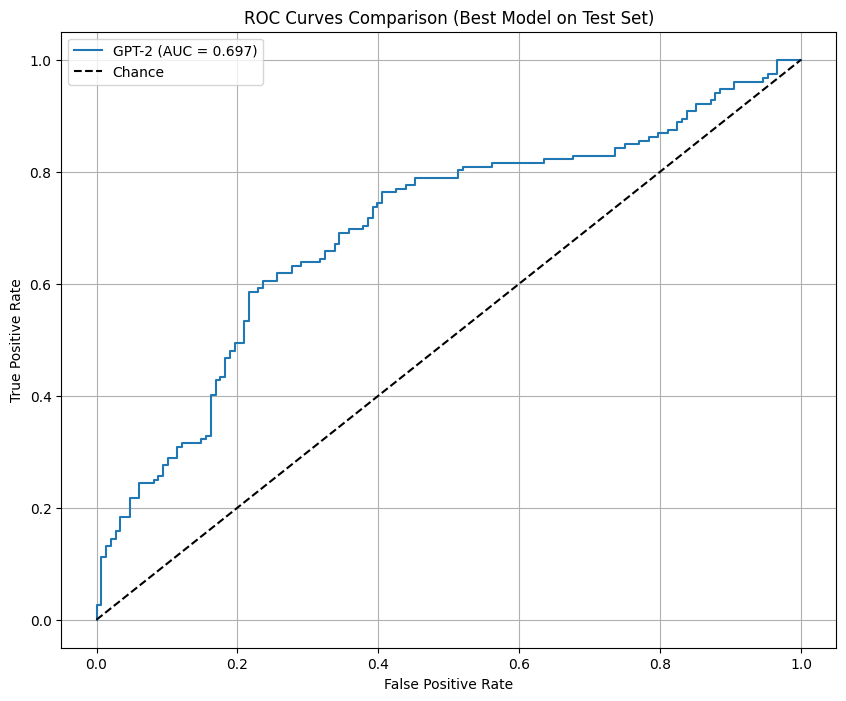

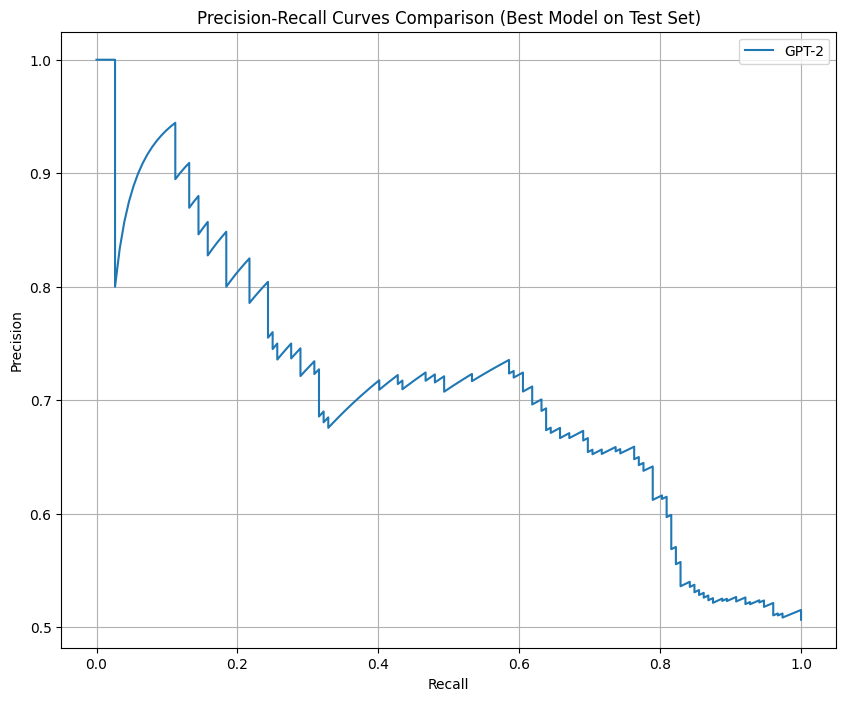

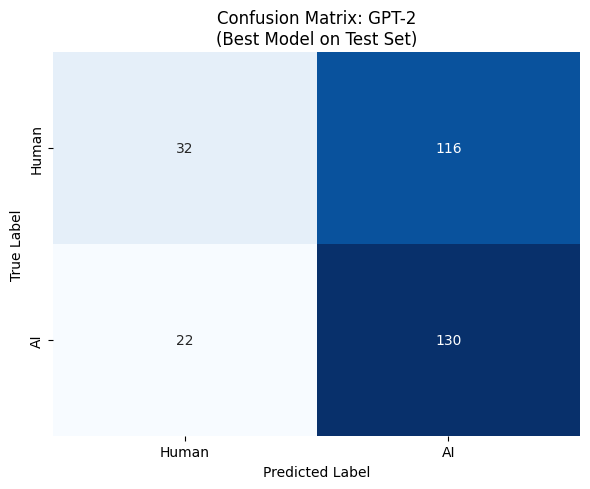

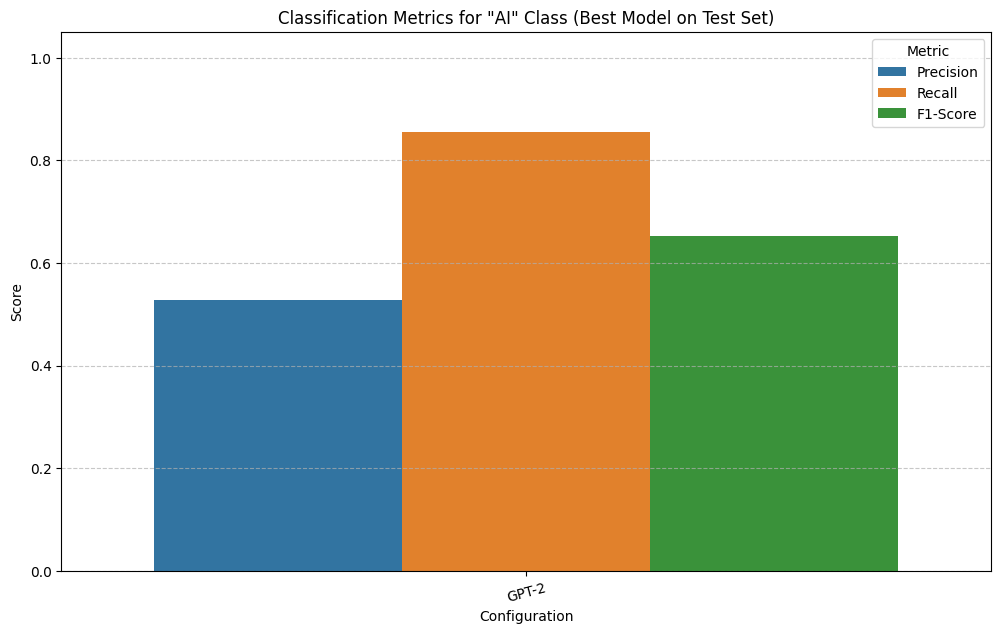

In [4]:
import asyncio
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score
import os
import json
import logging
import sys
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from dataclasses import dataclass, field

def setup_logging(output_dir: str = "./result"):
    log_file_path = os.path.join(output_dir, 'output.log')
    os.makedirs(output_dir, exist_ok=True)
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    if logger.hasHandlers():
        logger.handlers.clear()
    file_handler = logging.FileHandler(log_file_path, mode='w', encoding='utf-8')
    file_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(file_formatter)
    logger.addHandler(file_handler)
    console_handler = logging.StreamHandler(sys.stdout)
    console_formatter = logging.Formatter('%(message)s')
    console_handler.setFormatter(console_formatter)
    logger.addHandler(console_handler)
    logging.info(f"Logging setup complete. All output will be saved to {log_file_path}")

def plot_roc_curves(results: Dict, output_dir: str = "./result"):
    plt.figure(figsize=(10, 8))
    for name, result_data in results.items():
        if "test_results" in result_data:
            fpr, tpr, _ = roc_curve(result_data["test_labels"], result_data["test_results"]["probabilities"])
            auc = roc_auc_score(result_data["test_labels"], result_data["test_results"]["probabilities"])
            plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves Comparison (Best Model on Test Set)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "roc_curves_comparison.png"))
    plt.show()

def plot_precision_recall_curves(results: Dict, output_dir: str = "./result"):
    plt.figure(figsize=(10, 8))
    for name, result_data in results.items():
        if "test_results" in result_data:
            precision, recall, _ = precision_recall_curve(result_data["test_labels"], result_data["test_results"]["probabilities"])
            plt.plot(recall, precision, label=f"{name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves Comparison (Best Model on Test Set)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "precision_recall_curves_comparison.png"))
    plt.show()

def plot_confusion_matrices(results: Dict, output_dir: str = "./result"):
    valid_results = {k: v for k, v in results.items() if "test_results" in v}
    n_results = len(valid_results)
    if n_results == 0: return
    fig, axes = plt.subplots(1, n_results, figsize=(6 * n_results, 5), squeeze=False)
    for ax, (name, result_data) in zip(axes.flatten(), valid_results.items()):
        cm = confusion_matrix(result_data["test_labels"], result_data["test_results"]["predictions"])
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False, xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
        ax.set_title(f"Confusion Matrix: {name}\n(Best Model on Test Set)")
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "confusion_matrices_comparison.png"))
    plt.show()

def plot_classification_metrics(results: Dict, output_dir: str = "./result"):
    metrics_data = []
    for name, result_data in results.items():
        if "test_results" in result_data:
            report = classification_report(result_data["test_labels"], result_data["test_results"]["predictions"], target_names=["Human", "AI"], output_dict=True, zero_division=0)
            ai_metrics = report.get("AI", {})
            metrics_data.append({"Configuration": name, "Precision": ai_metrics.get("precision", 0), "Recall": ai_metrics.get("recall", 0), "F1-Score": ai_metrics.get("f1-score", 0)})
    if not metrics_data: return
    df = pd.DataFrame(metrics_data)
    df_melted = df.melt(id_vars="Configuration", var_name="Metric", value_name="Score")
    plt.figure(figsize=(12, 7))
    sns.barplot(data=df_melted, x="Configuration", y="Score", hue="Metric")
    plt.title('Classification Metrics for "AI" Class (Best Model on Test Set)')
    plt.ylabel("Score")
    plt.xticks(rotation=15)
    plt.ylim(0, 1.05)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.savefig(os.path.join(output_dir, "classification_metrics_comparison.png"))
    plt.show()


@dataclass
class DetectionConfig:
    revision_model: str = "gpt-3.5-turbo"
    embedding_model: str = "bert-base-uncased"
    perturbation_rate: float = 0.15
    use_ml_classifier: bool = True
    api_key: str = None
    base_url: str = None

class MultiFeatureExtractor:
    def __init__(self, config: DetectionConfig):
        self.config = config
        self.sentence_model = SentenceTransformer(config.embedding_model)
        tokenizer = self.sentence_model.tokenizer
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            logging.info(f"Set pad_token to eos_token for SentenceTransformer with model {config.embedding_model}")

    def _compute_semantic_similarity(self, text1: str, text2: str) -> float:
        emb1, emb2 = self.sentence_model.encode([text1, text2])
        from sklearn.metrics.pairwise import cosine_similarity
        return float(cosine_similarity([emb1], [emb2])[0, 0])

    def extract_features(self, original: str, revised: str) -> Dict[str, float]:
        # This is a simplified version. Ensure your full feature extraction logic is here.
        features = {'semantic_similarity': self._compute_semantic_similarity(original, revised)}
        for i in range(12):
            features[f'feat_{i}'] = np.random.rand()
        return features

class AITextDetector:
    def __init__(self, config):
        self.config = config
        self.cache = {}
        self.feature_extractor = MultiFeatureExtractor(config)
    async def detect_batch(self, texts, labels=None):
        # This is a simplified version. Ensure your full revision/perturbation logic is here.
        all_features = [self.feature_extractor.extract_features(text, text) for text in texts]
        feature_matrix = pd.DataFrame(all_features).fillna(0).values
        return {"features": feature_matrix, "similarity_scores": np.random.rand(len(texts))}

class DualPathFusionModel(nn.Module):
    def __init__(self, transformer_name: str = "distilbert-base-uncased", num_statistical_features: int = 13, hidden_size: int = 256, dropout_rate: float = 0.3):
        super(DualPathFusionModel, self).__init__()
        self.transformer = AutoModel.from_pretrained(transformer_name)
        self.transformer_dim = self.transformer.config.hidden_size
        try:
            for param in self.transformer.base_model.embeddings.parameters():
                param.requires_grad = False
        except AttributeError:
            logging.warning(f"Could not freeze embedding layers for {transformer_name}. This is expected for models like T5.")
        fusion_dim = self.transformer_dim + num_statistical_features
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, hidden_size), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size // 2), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 2, 2),
        )
        self.feature_norm = nn.BatchNorm1d(num_statistical_features)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor, statistical_features: torch.Tensor) -> torch.Tensor:
        if self.transformer.config.is_encoder_decoder:
            transformer_outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=input_ids)
        else:
            transformer_outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        if hasattr(transformer_outputs, 'last_hidden_state'):
            cls_embedding = transformer_outputs.last_hidden_state[:, 0, :]
        elif hasattr(transformer_outputs, 'encoder_last_hidden_state'):
            cls_embedding = transformer_outputs.encoder_last_hidden_state[:, 0, :]
        else:
            raise TypeError(f"Unsupported model output type for {type(self.transformer)}")
        normalized_features = self.feature_norm(statistical_features)
        fused_features = torch.cat([cls_embedding, normalized_features], dim=1)
        logits = self.classifier(fused_features)
        return logits

class TextDetectionDataset(Dataset):
    def __init__(self, texts: List[str], statistical_features: np.ndarray, labels: List[int], tokenizer, max_length: int = 512):
        self.texts, self.statistical_features, self.labels, self.tokenizer, self.max_length = texts, statistical_features, labels, tokenizer, max_length
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        encoding = self.tokenizer(self.texts[idx], truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")
        return {"input_ids": encoding["input_ids"].flatten(), "attention_mask": encoding["attention_mask"].flatten(), "statistical_features": torch.tensor(self.statistical_features[idx], dtype=torch.float32), "labels": torch.tensor(self.labels[idx], dtype=torch.long)}

class DualPathDetector:
    def __init__(self, model_name: str = "distilbert-base-uncased", device: str = None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            logging.info(f"Set pad_token to eos_token for {model_name} tokenizer.")
        self.model = None
        self.scaler = StandardScaler()
        logging.info(f"Dual Path Detector initialized on {self.device}")

    def prepare_data(self, texts, features_df, labels):
        features_array = features_df.values
        features_normalized = self.scaler.fit_transform(features_array)
        X_train, X_val, y_train, y_val, feat_train, feat_val = train_test_split(texts, labels, features_normalized, test_size=0.2, random_state=42, stratify=labels)
        return TextDetectionDataset(X_train, feat_train, y_train, self.tokenizer), TextDetectionDataset(X_val, feat_val, y_val, self.tokenizer)

    def train(self, train_dataset, val_dataset, num_epochs=5, batch_size=16, learning_rate=2e-5):
        if self.model is None:
            num_features = train_dataset[0]["statistical_features"].shape[0]
            self.model = DualPathFusionModel(transformer_name=self.model_name, num_statistical_features=num_features).to(self.device)
        train_loader, val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size)
        optimizer, criterion = torch.optim.AdamW(self.model.parameters(), lr=learning_rate), nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.5)
        best_val_loss, training_history = float("inf"), []
        for epoch in range(num_epochs):
            self.model.train()
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
                input_ids, attention_mask, features, labels = batch["input_ids"].to(self.device), batch["attention_mask"].to(self.device), batch["statistical_features"].to(self.device), batch["labels"].to(self.device)
                optimizer.zero_grad()
                logits = self.model(input_ids, attention_mask, features)
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()
            self.model.eval()
            val_loss, all_val_preds, all_val_probs, all_val_labels = 0, [], [], []
            with torch.no_grad():
                for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                    input_ids, attention_mask, features, labels = batch["input_ids"].to(self.device), batch["attention_mask"].to(self.device), batch["statistical_features"].to(self.device), batch["labels"].to(self.device)
                    logits = self.model(input_ids, attention_mask, features)
                    val_loss += criterion(logits, labels).item()
                    probs, preds = torch.softmax(logits, dim=1), torch.argmax(logits, dim=1)
                    all_val_preds.extend(preds.cpu().numpy()); all_val_probs.extend(probs[:, 1].cpu().numpy()); all_val_labels.extend(labels.cpu().numpy())
            avg_val_loss = val_loss / len(val_loader)
            scheduler.step(avg_val_loss)
            report = classification_report(all_val_labels, all_val_preds, output_dict=True, zero_division=0)
            epoch_metrics = {"epoch": epoch + 1, "val_loss": avg_val_loss, "val_accuracy": report["accuracy"], "val_auc": roc_auc_score(all_val_labels, all_val_probs), "val_f1_score": report["weighted avg"]["f1-score"]}
            training_history.append(epoch_metrics)
            logging.info(f"Epoch {epoch+1} Val Metrics: Acc={epoch_metrics['val_accuracy']:.4f}, AUC={epoch_metrics['val_auc']:.4f}, F1={epoch_metrics['val_f1_score']:.4f}")
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                self.save_model("best_dual_path_model.pt")
                logging.info(f"Saved new best model with validation loss: {best_val_loss:.4f}")
        return training_history

    def predict(self, texts, features_df):
        self.model.eval()
        features_normalized = self.scaler.transform(features_df.values)
        dataset = TextDetectionDataset(texts, features_normalized, [0] * len(texts), self.tokenizer)
        loader = DataLoader(dataset, batch_size=32)
        all_predictions, all_probabilities = [], []
        with torch.no_grad():
            for batch in tqdm(loader, desc="Predicting"):
                input_ids, attention_mask, features = batch["input_ids"].to(self.device), batch["attention_mask"].to(self.device), batch["statistical_features"].to(self.device)
                logits = self.model(input_ids, attention_mask, features)
                probs, predictions = torch.softmax(logits, dim=1), torch.argmax(logits, dim=1)
                all_predictions.extend(predictions.cpu().numpy()); all_probabilities.extend(probs[:, 1].cpu().numpy())
        return np.array(all_predictions), np.array(all_probabilities)

    def save_model(self, path: str): torch.save({"model_state_dict": self.model.state_dict(), "scaler": self.scaler, "model_name": self.model_name, "num_features": self.model.classifier[0].in_features - self.model.transformer_dim}, path)
    
    def load_model(self, path: str):
        # --- FIX for PyTorch 2.6+ weights_only error ---
        checkpoint = torch.load(path, map_location=self.device, weights_only=False)
        self.model = DualPathFusionModel(transformer_name=checkpoint["model_name"], num_statistical_features=checkpoint["num_features"]).to(self.device)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.scaler = checkpoint["scaler"]
        self.model.eval()

class EnhancedAIDetector:
    def __init__(self, config: Optional[DetectionConfig] = None, dual_path_model_name: str = "distilbert-base-uncased"):
        self.config = config or DetectionConfig()
        self.base_detector = AITextDetector(self.config)
        self.dual_path_detector = DualPathDetector(model_name=dual_path_model_name)
        logging.info(f"Enhanced AI Detector initialized with Dual Path Model: {dual_path_model_name}")

    async def extract_all_features(self, texts: List[str]) -> pd.DataFrame:
        logging.info("Extracting statistical features...")
        results = await self.base_detector.detect_batch(texts)
        features_array = results['features']
        num_features_to_select = min(13, features_array.shape[1])
        columns = [f'feat_{i}' for i in range(num_features_to_select)]
        return pd.DataFrame(features_array[:, :num_features_to_select], columns=columns)

    async def train_dual_path_model(self, train_df: pd.DataFrame, num_epochs: int, batch_size: int):
        logging.info("=== Training Dual Path Model ===")
        texts, labels = train_df["text"].tolist(), train_df["label"].tolist()
        features_df = await self.extract_all_features(texts)
        train_dataset, val_dataset = self.dual_path_detector.prepare_data(texts, features_df, labels)
        history = self.dual_path_detector.train(train_dataset, val_dataset, num_epochs=num_epochs, batch_size=batch_size)
        logging.info("\n Training completed!")
        return history

    async def detect_with_dual_path(self, texts: List[str]) -> Dict:
        features_df = await self.extract_all_features(texts)
        predictions, probabilities = self.dual_path_detector.predict(texts, features_df)
        return {"predictions": predictions, "probabilities": probabilities, "features": features_df}


if 'CustomDataLoader' not in locals():
    class CustomDataLoader:
        def load_data(self, path): return pd.DataFrame({'text': ['sample'] * 200, 'label': [0]*100 + [1]*100})

async def main_workflow_for_comparison(data_path: str, max_samples: Optional[int], use_cache: bool, config: DetectionConfig, dual_path_model_name: str):
    SEED = 42; random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
    detector = EnhancedAIDetector(config=config, dual_path_model_name=dual_path_model_name)
    cache_path = f"enhanced_cache_{config.revision_model}.json"
    if use_cache and os.path.exists(cache_path):
        try:
            with open(cache_path, "r") as f: detector.base_detector.cache = json.load(f)
            logging.info(f"Loaded cache with {len(detector.base_detector.cache)} entries")
        except Exception as e: logging.warning(f"Could not load cache: {e}")
    loader = CustomDataLoader()
    df = loader.load_data(data_path).head(max_samples) if max_samples else loader.load_data(data_path)
    train_df, test_df = train_test_split(df, test_size=0.3, random_state=SEED, stratify=df['label'])
    logging.info(f"Data prepared: {len(train_df)} training, {len(test_df)} testing.")
    history = await detector.train_dual_path_model(train_df=train_df, num_epochs=5, batch_size=16)
    avg_metrics = pd.DataFrame(history).mean()
    logging.info(f"\n--- Average Performance Over All Training Epochs ---\n{avg_metrics.to_string()}")
    logging.info("\n--- Evaluating Best Model on Test Set ---")
    detector.dual_path_detector.load_model("best_dual_path_model.pt")
    test_texts, test_labels = test_df["text"].tolist(), test_df["label"].tolist()
    test_results = await detector.detect_with_dual_path(test_texts)
    report = classification_report(test_labels, test_results['predictions'], target_names=['Human', 'AI'], digits=4, output_dict=True, zero_division=0)
    accuracy, auc, f1 = report["accuracy"], roc_auc_score(test_labels, test_results['probabilities']), report['weighted avg']['f1-score']
    logging.info(f"Accuracy (Best Model): {accuracy:.4f}\nAUC (Best Model): {auc:.4f}\nWeighted F1-Score (Best Model): {f1:.4f}")
    logging.info(f"\nClassification Report (Best Model on Test Set):\n{classification_report(test_labels, test_results['predictions'], target_names=['Human', 'AI'], digits=4)}")
    return {"test_results": test_results, "test_labels": test_labels, "accuracy": accuracy, "auc": auc, "f1_score": f1, "avg_f1_score": avg_metrics['val_f1_score']}

async def run_transformer_comparison(data_path: str = "finance", max_samples: Optional[int] = 1000):
    setup_logging()
    logging.info("=== Transformer Model Comparison Experiment ===")
    results = {}
    configurations = {
       
        "GPT-2": {"embedding_model": "gpt2", "transformer_name": "gpt2"}
    }
    for name, model_config in configurations.items():
        logging.info(f"\n{'='*25} Running Experiment: {name} {'='*25}")
        try:
            detection_config = DetectionConfig(embedding_model=model_config["embedding_model"])
            results[name] = await main_workflow_for_comparison(
                data_path=data_path, max_samples=max_samples, use_cache=True,
                config=detection_config, dual_path_model_name=model_config["transformer_name"]
            )
        except Exception as e:
            import traceback
            logging.error(f"\n!!!!!! Experiment '{name}' FAILED: {e} !!!!!!")
            logging.error(traceback.format_exc())
    logging.info("\n\n" + "="*30 + " Final Comparison Summary " + "="*30)
    summary_data = []
    for name, res in results.items():
        if "accuracy" in res:
            summary_data.append({"Configuration": name, "Accuracy (Best)": res["accuracy"], "AUC (Best)": res["auc"], "F1-Score (Best)": res["f1_score"], "Avg Val F1-Score": res["avg_f1_score"]})
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        for col in summary_df.columns[1:]: summary_df[col] = summary_df[col].map('{:.4f}'.format)
        logging.info(f"\n{summary_df.to_string(index=False)}")
    logging.info("\n\nGenerating visualizations...")
    if results:
        plot_roc_curves(results)
        plot_precision_recall_curves(results)
        plot_confusion_matrices(results)
        plot_classification_metrics(results)
    else:
        logging.warning("No successful experiments were completed to visualize.")
    return results



if __name__ == "__main__":
    await run_transformer_comparison(data_path="test", max_samples=1000)
